In [1]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [3]:
from imblearn.over_sampling import SMOTE

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [4]:
train_data = pd.read_pickle('train_data_mutual_info_classif.pkl')

In [5]:
train_data.head()

ProductCD  card3  card4  card6  addr2  R_emaildomain       D12       D13   
0          4     42      1      1     65             31 -1.416108 -1.833103  \
1          4     42      2      1     65             31 -1.416108 -1.833103   
2          4     42      4      2     65             31 -1.416108 -1.833103   
3          4     42      2      2     65             31 -1.416108 -1.833103   
4          1     42      2      1     65             31 -1.217018  0.281952   

   M1  M2  M3  M4  M5  M7  M8  M9       V18       V30      V40      V60   
0   1   1   1   2   0   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961  \
1   2   2   2   0   1   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961   
2   1   1   1   0   0   0   0   0 -0.540222 -0.664176 -0.50417 -0.51961   
3   2   2   2   0   1   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961   
4   2   2   2   3   2   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961   

        V70       V80       V81       V91      V173      V174      V223   
0 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947  \
1 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947   
2 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947   
3 -0.664404 -0.521953 -0.508172 -0.694394 -0.105190  0.854764  0.815741   
4 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947   

   id_12  id_13  id_15  id_16  id_17  id_19  id_20  id_28  id_29  id_30   
0      2     54      3      2    104    522    394      2      2     74  \
1      2     54      3      2    104    522    394      2      2     74   
2      2     54      3      2    104    522    394      2      2     74   
3      2     54      3      2    104    522    394      2      2     74   
4      1     54      1      1     59    400     32      1      1      7   

   id_33  id_35  id_36  id_37  DeviceType  DeviceInfo  R_parent_domain   
0    260      2      2      2           1        1735               16  \
1    260      2      2      2           1        1735               16   
2    260      2      2      2           1        1735               16   
3    260      2      2      2           1        1735               16   
4    164      1      0      1           2         954               16   

   R_domain_name  R_top_level_domain  device_name  device_version  os_name   
0             24                   8           13             293        7  \
1             24                   8           13             293        7   
2             24                   8           13             293        7   
3             24                   8           13             293        7   
4             24                   8            7             249        0   

   os_version  TransactionAmt  isFraud  
0          68       -0.278167        0  
1          68       -0.443327        0  
2          68       -0.317889        0  
3          68       -0.355521        0  
4          58       -0.355521        0

In [9]:
for col in train_data.columns:
    print(col)

ProductCD
card3
card4
card6
addr2
R_emaildomain
D12
D13
M1
M2
M3
M4
M5
M7
M8
M9
V18
V30
V40
V60
V70
V80
V81
V91
V173
V174
V223
id_12
id_13
id_15
id_16
id_17
id_19
id_20
id_28
id_29
id_30
id_33
id_35
id_36
id_37
DeviceType
DeviceInfo
R_parent_domain
R_domain_name
R_top_level_domain
device_name
device_version
os_name
os_version
TransactionAmt
isFraud


In [6]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(729354, 51)
(729354,)


In [11]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(28010, 51)
(28010,)


In [12]:
y_train_smote.value_counts(normalize=True)

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

In [13]:
y_train_resampled.value_counts(normalize=True)

isFraud
0    0.526312
1    0.473688
Name: proportion, dtype: float64

In [14]:
K.clear_session()

In [15]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_baseline/undersampled/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_auc", mode="max", patience=10)


# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_resampled.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    # recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[auc])

    return model


In [16]:
from keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model = create_baseline_model(adam)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               26624     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 158,209
Trainable params: 158,209
Non-trainable params: 0
_________________________________________________________________


# Undersampled Data

In [29]:
## Undersampled Data
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model = create_baseline_model(adam)
# history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=512, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 18.4917 - auc: 0.5357
Epoch 1: val_auc improved from -inf to 0.69517, saving model to ./model/model_reduced_features_baseline/undersampled/base_model_logloss_6.58_auc_0.70_checkpoint.h5
55/55 [==============================] - 11s 200ms/step - loss: 18.4917 - auc: 0.5357 - val_loss: 6.5817 - val_auc: 0.6952
Epoch 2/50
51/55 [==========================>...] - ETA: 0s - loss: 10.2585 - auc: 0.5661
Epoch 2: val_auc improved from 0.69517 to 0.69804, saving model to ./model/model_reduced_features_baseline/undersampled/base_model_logloss_6.17_auc_0.70_checkpoint.h5
55/55 [==============================] - 1s 25ms/step - loss: 10.1325 - auc: 0.5655 - val_loss: 6.1746 - val_auc: 0.6980
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 6.2623 - auc: 0.5760
Epoch 3: val_auc improved from 0.69804 to 0.71516, saving model to ./model/model_reduced_features_baseline/undersampled/base_model_logloss_2.11_auc_0.72_che

In [30]:
import seaborn as sns

<Axes: xlabel='epoch', ylabel='auc'>

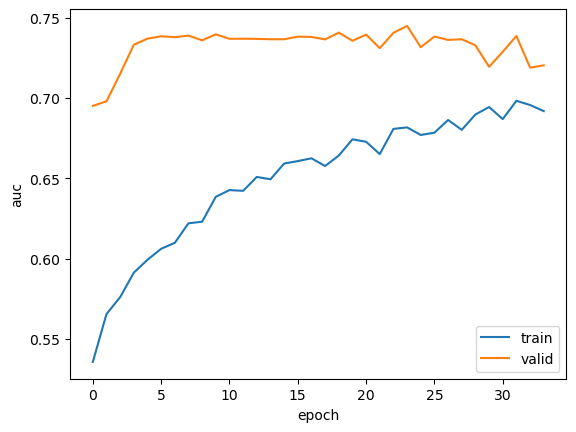

In [31]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [70]:
model_rus = keras.models.load_model('model/model_reduced_features_baseline/undersampled/base_model_logloss_0.97_auc_0.73_checkpoint.h5')

In [71]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

In [72]:
y_pred_rus = model_rus.predict(X_test)
# using x test here

3691/3691 [==============================] - 6s 1ms/step


In [78]:
y_pred_keras = y_pred_rus.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras_rus = auc(fpr_keras, tpr_keras)
avg_prec_score = average_precision_score(y_test, y_pred_rus)
print(f"AUC for Undersampled: {auc_keras_rus}")
print(f"Average Precision Score for Undersampled: {avg_prec_score}")

AUC for Undersampled: 0.7435025962783847
Average Precision Score for Undersampled: 0.10166180223860835


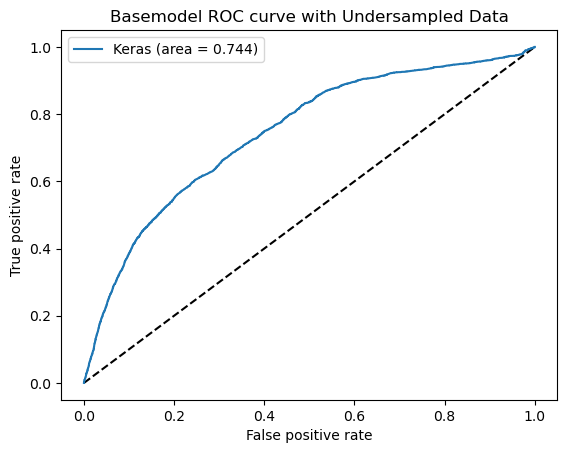

In [74]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Basemodel ROC curve with Undersampled Data')
plt.legend(loc='best')
plt.show()

In [75]:
temp = X_test.copy()
temp['predicted'] = y_pred_rus
temp['true'] = y_test
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

In [38]:
temp.head()

ProductCD  card3  card4  card6  addr2  R_emaildomain       D12   
7681            1     42      4      1     65             31 -1.416108  \
570242          4     42      2      2     65             31  0.614603   
340470          0     73      2      1     43             19 -0.801775   
131781          2     42      4      1     65              1  0.614603   
472772          4     42      4      2     65             31  0.614603   

             D13  M1  M2  M3  M4  M5  M7  M8  M9       V18       V30   
7681   -1.819843   2   2   2   3   2   2   2   2 -0.540222 -0.664176  \
570242  0.533902   1   1   1   0   0   0   0   0 -0.540222 -0.664176   
340470  0.533902   2   2   2   2   2   2   2   2 -0.540222 -0.664176   
131781 -1.833103   2   2   2   3   2   2   2   2  1.683197 -0.664176   
472772  0.533902   1   1   1   3   2   0   1   1 -0.540222  1.202141   

             V40       V60       V70       V80       V81       V91      V173   
7681   -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703  \
570242 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
340470 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
131781  2.095003  1.524002 -0.664404  1.464129  1.372312 -0.694394 -1.102703   
472772 -0.504170 -0.519610  1.204801 -0.521953 -0.508172  1.128298  0.892322   

            V174      V223  id_12  id_13  id_15  id_16  id_17  id_19  id_20   
7681   -1.135389 -1.072947      1     54      0      0     59    389     51  \
570242  0.854764  0.815741      2     54      3      2    104    522    394   
340470  0.854764  0.815741      2     54      3      2    104    522    394   
131781 -1.135389 -1.072947      1     38      1      1     59    227    125   
472772  0.854764  0.815741      2     54      3      2    104    522    394   

        id_28  id_29  id_30  id_33  id_35  id_36  id_37  DeviceType   
7681        0      0     16    132      1      0      1           0  \
570242      2      2     74    260      2      2      2           1   
340470      2      2     74    260      2      2      2           1   
131781      1      1     56     14      1      0      1           2   
472772      2      2     74    260      2      2      2           1   

        DeviceInfo  R_parent_domain  R_domain_name  R_top_level_domain   
7681          1769               16             24                   8  \
570242        1735               16             24                   8   
340470        1735               15             17                   2   
131781        1727                1              1                   2   
472772        1735               16             24                   8   

        device_name  device_version  os_name  os_version  TransactionAmt   
7681              6             293        3           5       -0.460052  \
570242           13             293        7          68       -0.075376   
340470           13             293        7          68       -0.256120   
131781           12             293        6          11        1.107920   
472772           13             293        7          68       -0.430993   

        predicted  true  
7681     0.079156     0  
570242   0.374459     0  
340470   0.915561     0  
131781   0.704168     0  
472772   0.298058     0

In [ ]:
# per row consider apakah dia tp, fp, fn, tn dengan bikin 4 kolom
# group by bin
# dihitung cumulative sum untuk setiap tp fp fn tn
# ini berubah seiring threshold berubah
# non-cumulative ngitung precision itu di bin itu doang (bins nya adalah populasi)
# fraud rate
# masukin y_val
# transaksi masuk, kemungkinan dia dihitung fraud berapa? -> fraud rate

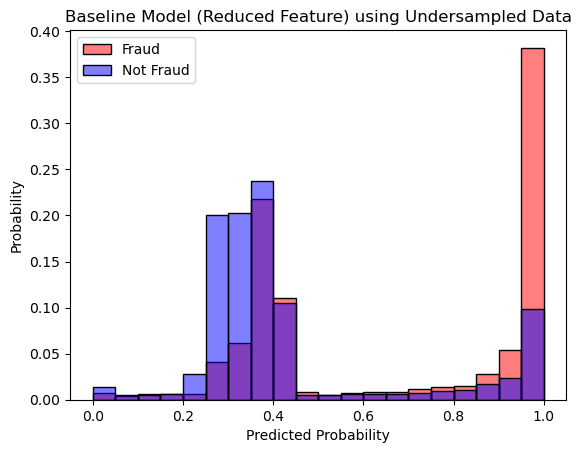

In [76]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model (Reduced Feature) using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

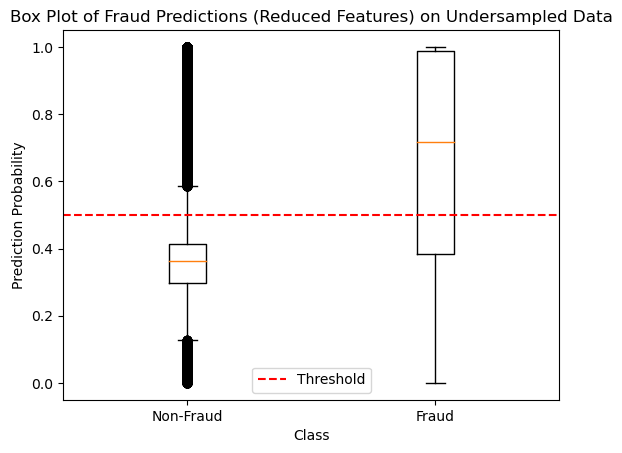

In [77]:
fraud_cases = y_pred_rus[y_test==1]
non_fraud_cases = y_pred_rus[y_test==0]
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.39. Let's calculate the confusion matrix

Threshold: 0.3


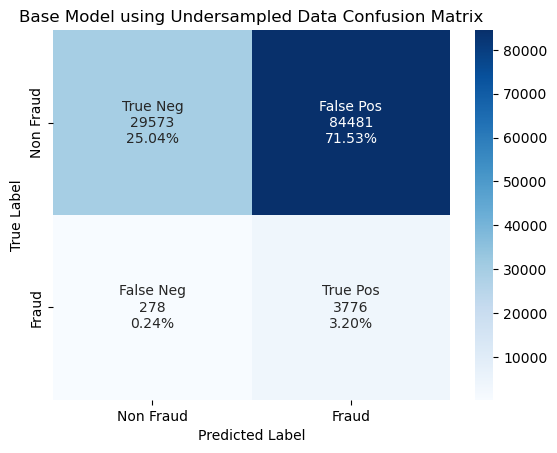

Metrics when threshold is 0.3: 

False Positive Rate: 0.7407105406211093
Recall: 0.9314257523433646
Precision: 0.04278414176779179
Accuracy: 0.28236021268669353
F1: 0.08181040179393573
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.31


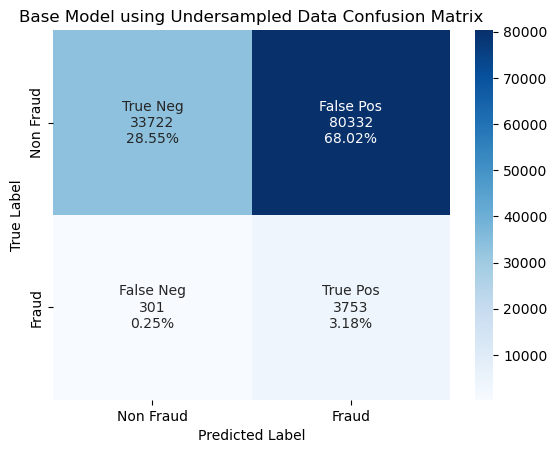

Metrics when threshold is 0.31: 

False Positive Rate: 0.7043330352289267
Recall: 0.9257523433645782
Precision: 0.04463340667182018
Accuracy: 0.31729434077285196
F1: 0.08516093897139745
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.32


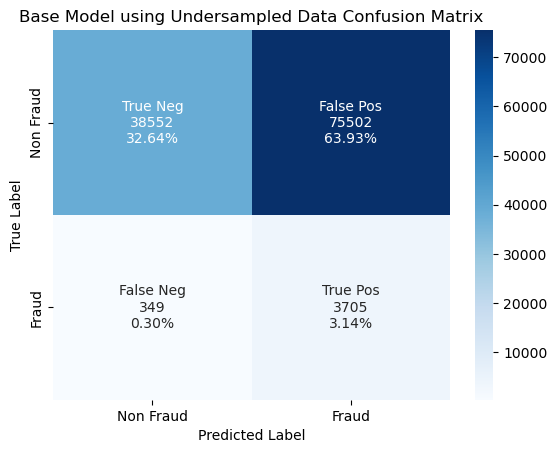

Metrics when threshold is 0.32: 

False Positive Rate: 0.6619846739263857
Recall: 0.9139121854958067
Precision: 0.046776168772961986
Accuracy: 0.35778270735259254
F1: 0.0889972496126638
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.33


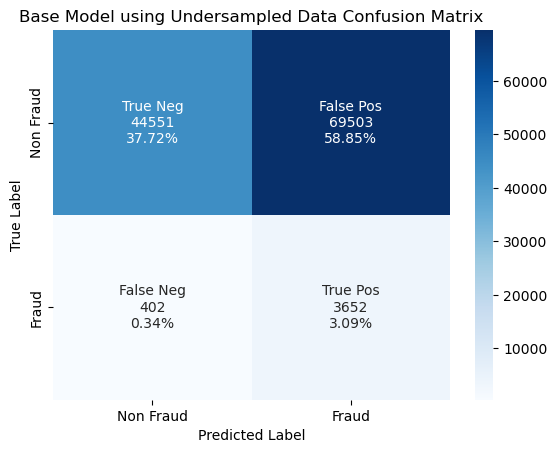

Metrics when threshold is 0.33: 

False Positive Rate: 0.6093867816998966
Recall: 0.900838677849038
Precision: 0.049921399767616705
Accuracy: 0.40812646052765267
F1: 0.09460037042313721
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.34


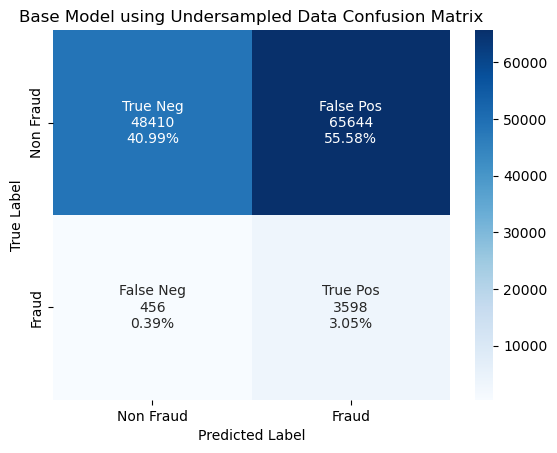

Metrics when threshold is 0.34: 

False Positive Rate: 0.5755519315411998
Recall: 0.88751850024667
Precision: 0.051962681609427804
Accuracy: 0.4403427371558235
F1: 0.09817725387469985
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.35


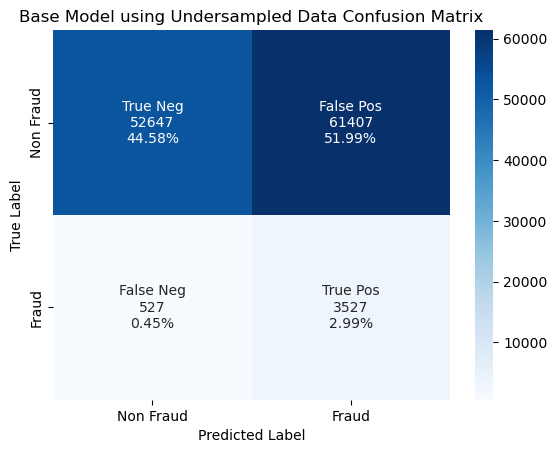

Metrics when threshold is 0.35: 

False Positive Rate: 0.5384028618023041
Recall: 0.870004933399112
Precision: 0.054316690793729014
Accuracy: 0.4756155383208589
F1: 0.10224966660868556
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.36


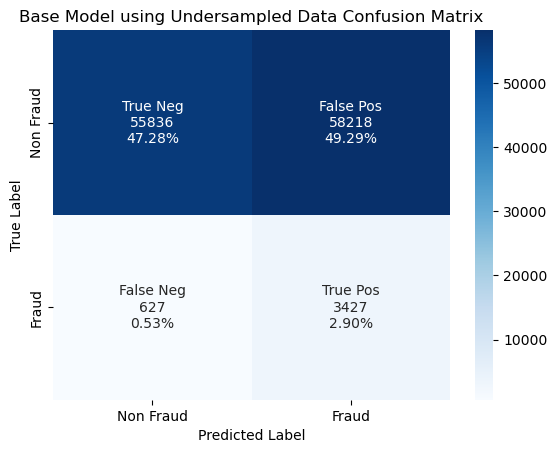

Metrics when threshold is 0.36: 

False Positive Rate: 0.5104424220106265
Recall: 0.8453379378391712
Precision: 0.05559250547489659
Accuracy: 0.5017695668371321
F1: 0.10432426673160931
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.37


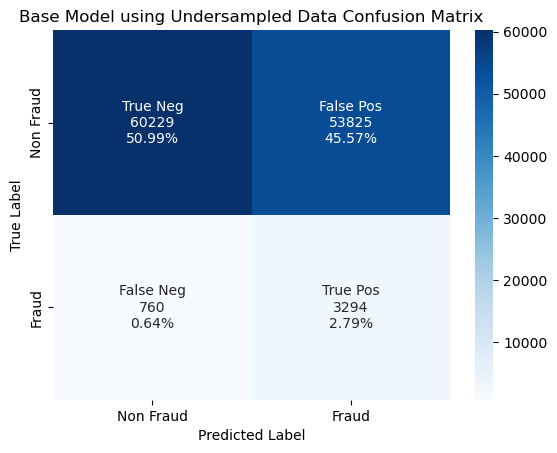

Metrics when threshold is 0.37: 

False Positive Rate: 0.47192557911164884
Recall: 0.8125308337444499
Precision: 0.05766907683958052
Accuracy: 0.5378382497375284
F1: 0.10769457113432397
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.38


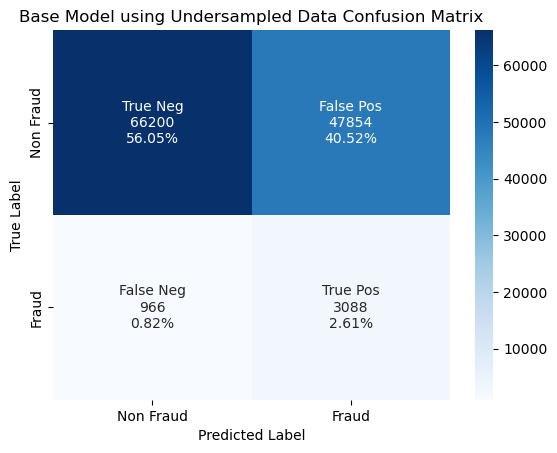

Metrics when threshold is 0.38: 

False Positive Rate: 0.41957318463184107
Recall: 0.7617168228909719
Precision: 0.060617957677358565
Accuracy: 0.5866495072306702
F1: 0.11229907629645793
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.39


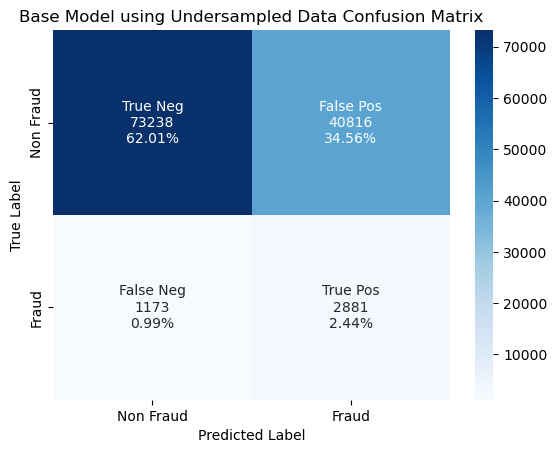

Metrics when threshold is 0.39: 

False Positive Rate: 0.3578655724481386
Recall: 0.7106561420818944
Precision: 0.06593129963155366
Accuracy: 0.644486402275883
F1: 0.12066762999727755
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.4


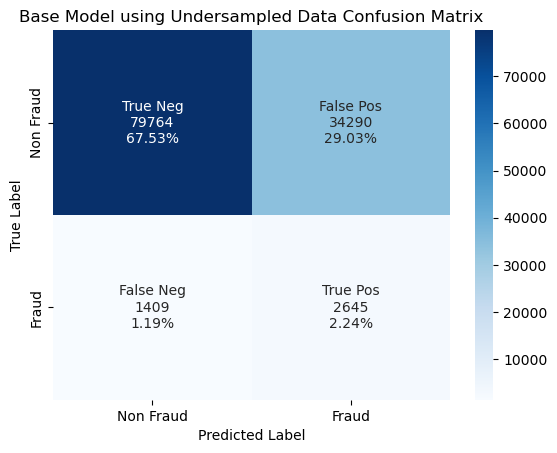

Metrics when threshold is 0.4: 

False Positive Rate: 0.3006470619180388
Recall: 0.6524420325604341
Precision: 0.07161229186408556
Accuracy: 0.697742743929285
F1: 0.1290590158335163
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.41


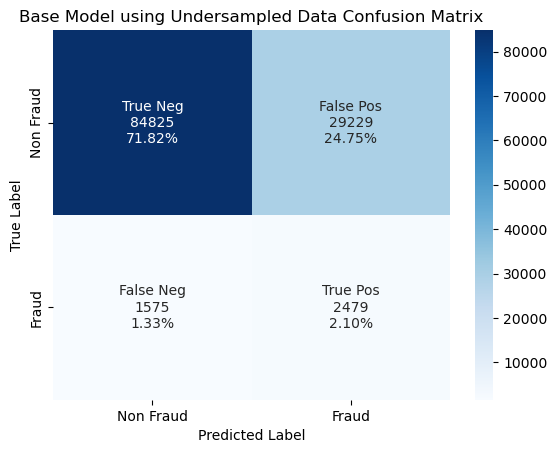

Metrics when threshold is 0.41: 

False Positive Rate: 0.2562733442053764
Recall: 0.6114948199309325
Precision: 0.07818216223035196
Accuracy: 0.739187861956853
F1: 0.13863877859180135
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.42


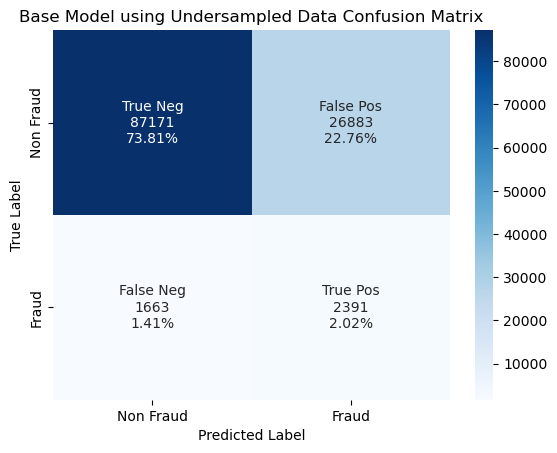

Metrics when threshold is 0.42: 

False Positive Rate: 0.23570414014414226
Recall: 0.5897878638381845
Precision: 0.08167657306825168
Accuracy: 0.7583059572594575
F1: 0.1434829572731637
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.43


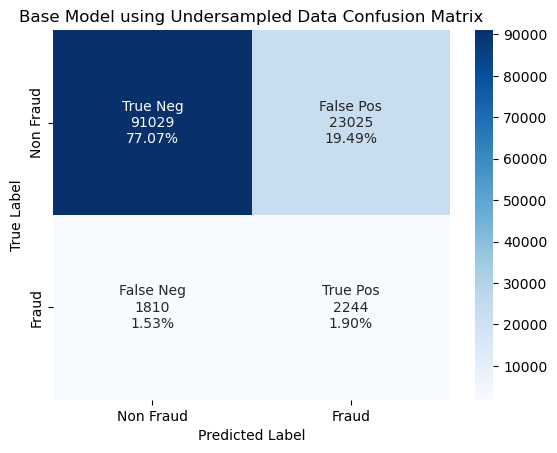

Metrics when threshold is 0.43: 

False Positive Rate: 0.20187805776211268
Recall: 0.5535273803650715
Precision: 0.08880446396770747
Accuracy: 0.7897263521522674
F1: 0.15305391672066296
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.44


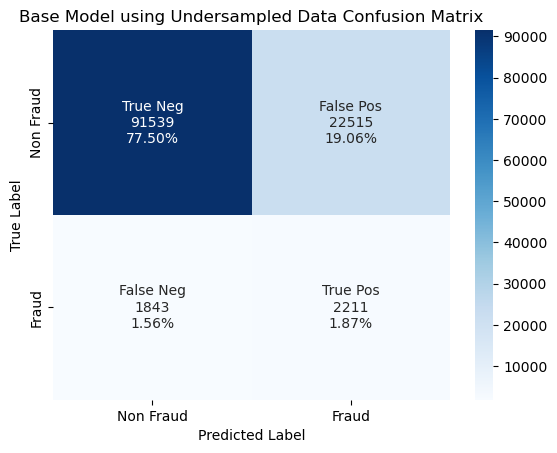

Metrics when threshold is 0.44: 

False Positive Rate: 0.1974064916618444
Recall: 0.5453872718302911
Precision: 0.08942004367871875
Accuracy: 0.7937650286178751
F1: 0.1536483669214732
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.45


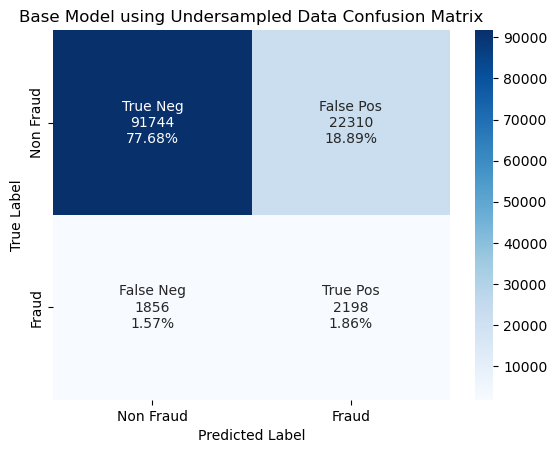

Metrics when threshold is 0.45: 

False Positive Rate: 0.19560909744506988
Recall: 0.5421805624074988
Precision: 0.08968500081606007
Accuracy: 0.7953906593964846
F1: 0.1539107905608851
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.46


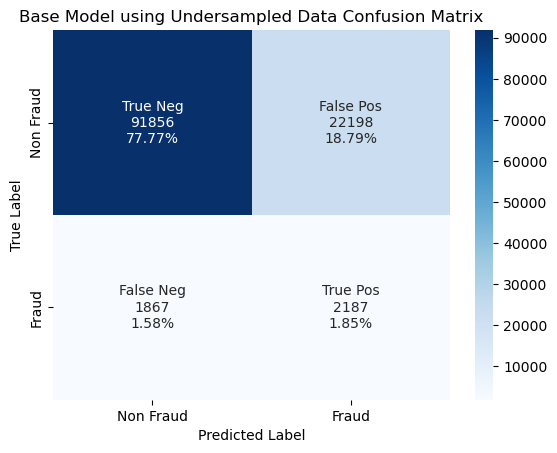

Metrics when threshold is 0.46: 

False Positive Rate: 0.1946271064583443
Recall: 0.5394671928959053
Precision: 0.08968628255074841
Accuracy: 0.7962458089206489
F1: 0.1538028763317979
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.47


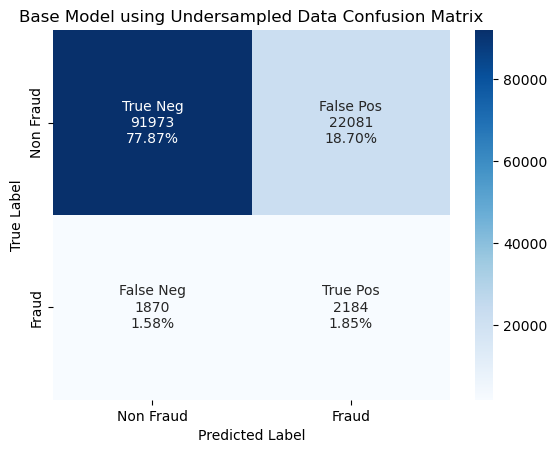

Metrics when threshold is 0.47: 

False Positive Rate: 0.19360127658828274
Recall: 0.538727183029107
Precision: 0.0900061817432516
Accuracy: 0.7972110271954482
F1: 0.15424273455983617
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.48


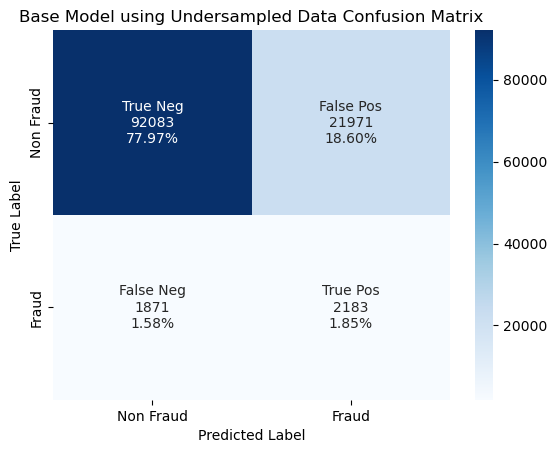

Metrics when threshold is 0.48: 

False Positive Rate: 0.19263682115489153
Recall: 0.5384805130735076
Precision: 0.09037840523308768
Accuracy: 0.7981339113353879
F1: 0.1547787861599546
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.49


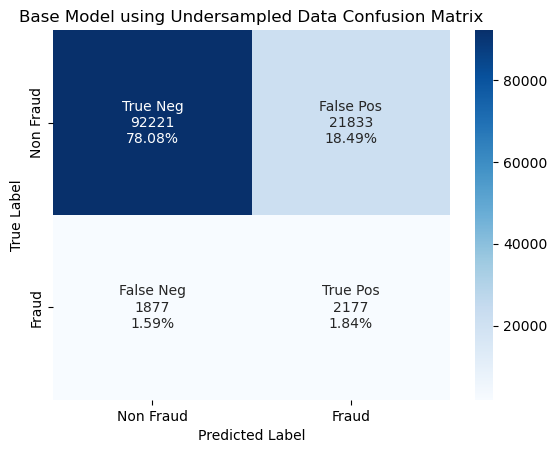

Metrics when threshold is 0.49: 

False Positive Rate: 0.19142686797481895
Recall: 0.5370004933399112
Precision: 0.09067055393586006
Accuracy: 0.7992515324956819
F1: 0.1551453819840365
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.5


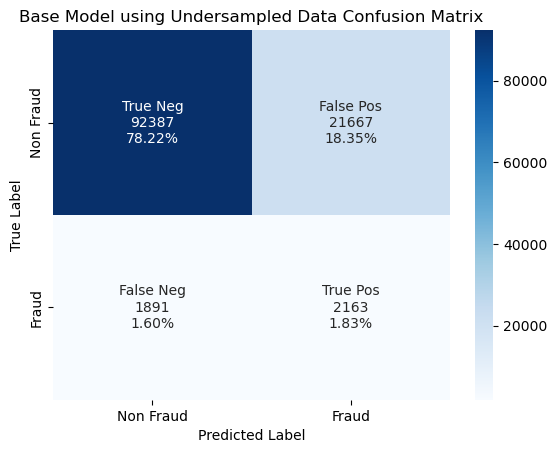

Metrics when threshold is 0.5: 

False Positive Rate: 0.18997141704806494
Recall: 0.5335471139615194
Precision: 0.0907679395719681
Accuracy: 0.8005384901954143
F1: 0.15514273418447852
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.51


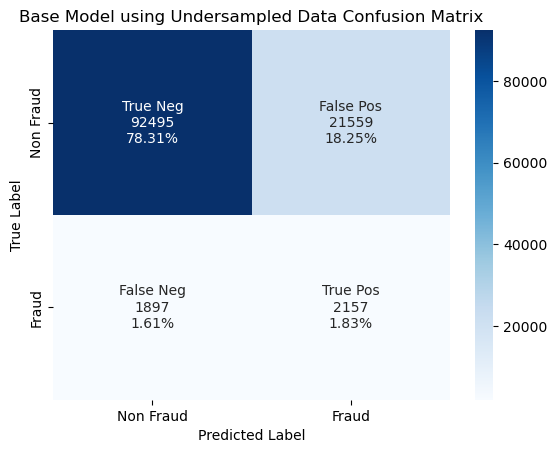

Metrics when threshold is 0.51: 

False Positive Rate: 0.18902449716800815
Recall: 0.5320670942279231
Precision: 0.09095125653567213
Accuracy: 0.8014021065465506
F1: 0.15534749729924377
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.52


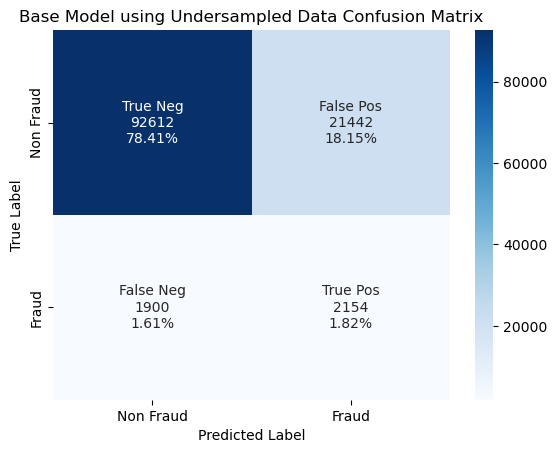

Metrics when threshold is 0.52: 

False Positive Rate: 0.1879986672979466
Recall: 0.5313270843611249
Precision: 0.09128665875572131
Accuracy: 0.80236732482135
F1: 0.15580470162748647
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.53


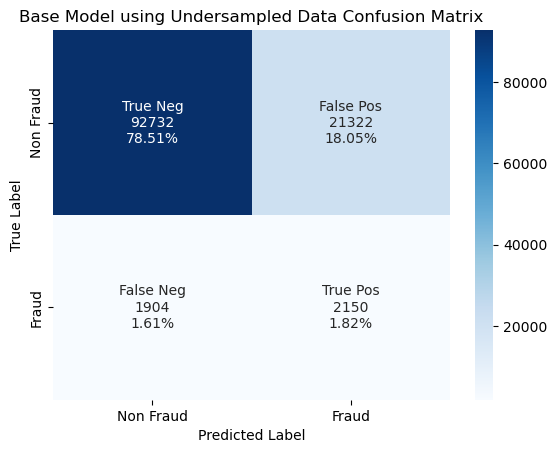

Metrics when threshold is 0.53: 

False Positive Rate: 0.18694653409788345
Recall: 0.5303404045387272
Precision: 0.09159850034083163
Accuracy: 0.8033494767500932
F1: 0.1562159412918695
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.54


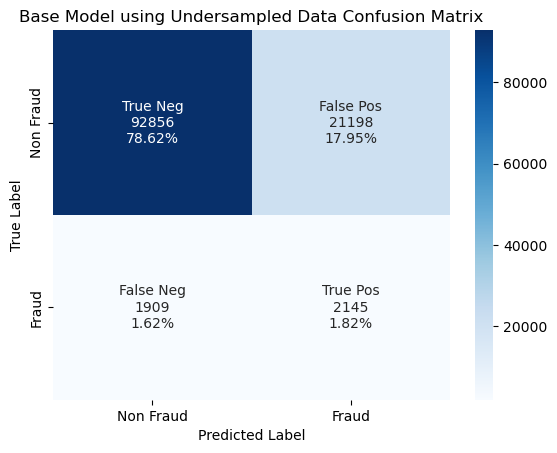

Metrics when threshold is 0.54: 

False Positive Rate: 0.18585932979115155
Recall: 0.5291070547607302
Precision: 0.09189050250610462
Accuracy: 0.804357029159752
F1: 0.15658648757163193
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.55


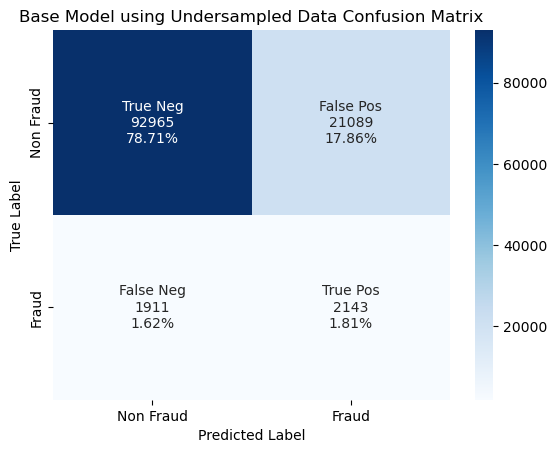

Metrics when threshold is 0.55: 

False Positive Rate: 0.18490364213442756
Recall: 0.5286137148495313
Precision: 0.09224345730027549
Accuracy: 0.805262979645748
F1: 0.157076889247233
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.56


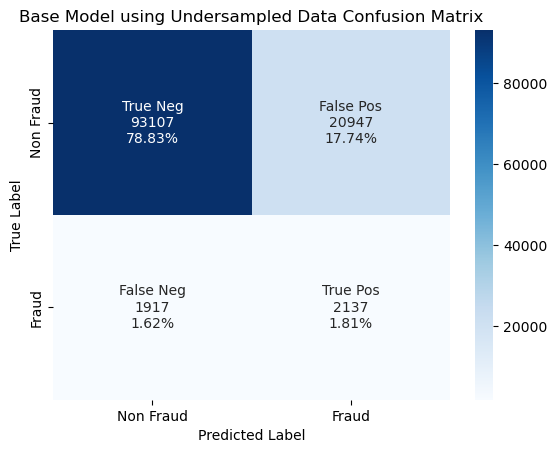

Metrics when threshold is 0.56: 

False Positive Rate: 0.1836586178476862
Recall: 0.5271336951159349
Precision: 0.09257494368393693
Accuracy: 0.8064144681139296
F1: 0.15749134055567837
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.57


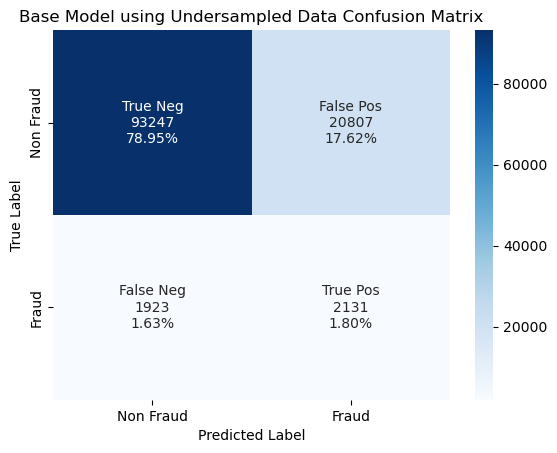

Metrics when threshold is 0.57: 

False Positive Rate: 0.1824311291142792
Recall: 0.5256536753823384
Precision: 0.09290260702763972
Accuracy: 0.8075490229281674
F1: 0.15789863663307646
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.58


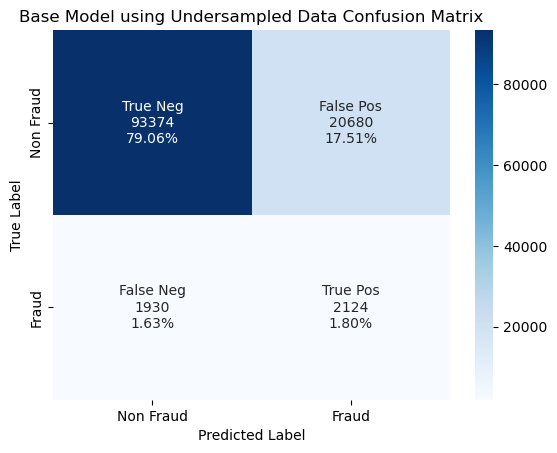

Metrics when threshold is 0.58: 

False Positive Rate: 0.18131762147754574
Recall: 0.5239269856931426
Precision: 0.09314155411331346
Accuracy: 0.8085650421647983
F1: 0.15816516494154442
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.59


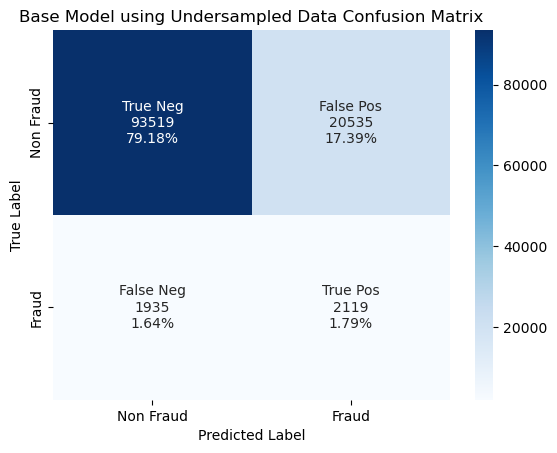

Metrics when threshold is 0.59: 

False Positive Rate: 0.1800462938608028
Recall: 0.5226936359151455
Precision: 0.09353756510991436
Accuracy: 0.8097503979408677
F1: 0.15867904747641154
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.6


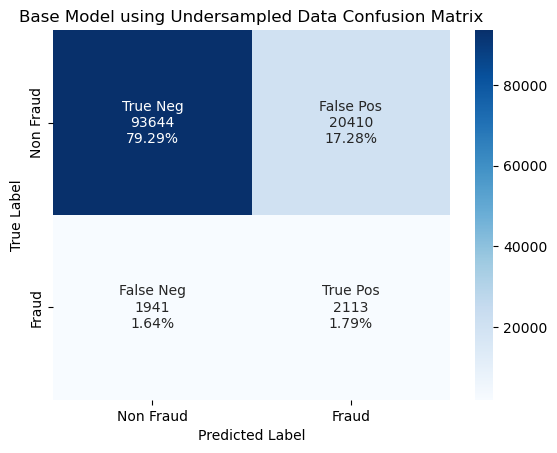

Metrics when threshold is 0.6: 

False Positive Rate: 0.1789503217774037
Recall: 0.521213616181549
Precision: 0.0938152111175243
Accuracy: 0.8107579503505267
F1: 0.15900967001542685
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.61


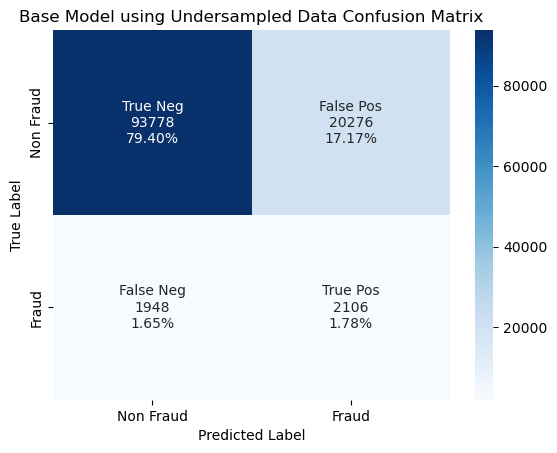

Metrics when threshold is 0.61: 

False Positive Rate: 0.17777543970399987
Recall: 0.5194869264923533
Precision: 0.09409346796532929
Accuracy: 0.811833237375961
F1: 0.15932818883340902
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.62


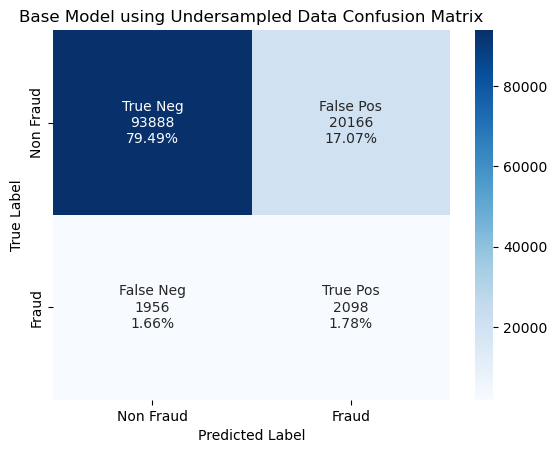

Metrics when threshold is 0.62: 

False Positive Rate: 0.17681098427060865
Recall: 0.517513566847558
Precision: 0.09423284225655768
Accuracy: 0.8126968537270972
F1: 0.1594346074929706
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.63


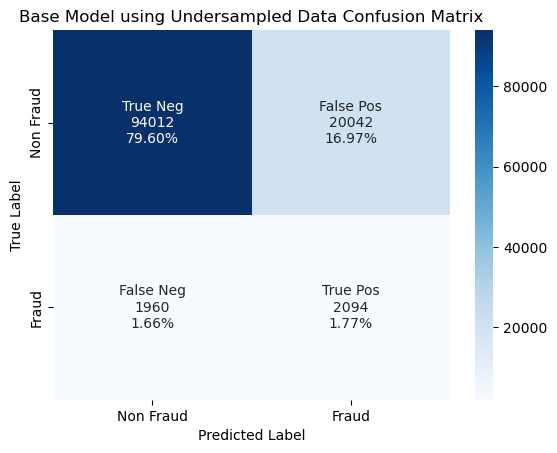

Metrics when threshold is 0.63: 

False Positive Rate: 0.17572377996387675
Recall: 0.5165268870251604
Precision: 0.0945970365016263
Accuracy: 0.8137128729637281
F1: 0.15990836197021763
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.64


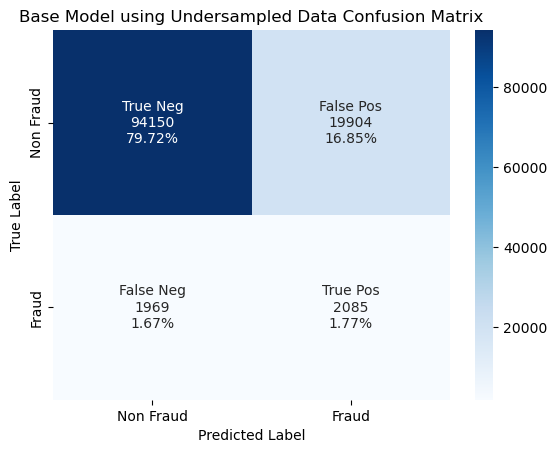

Metrics when threshold is 0.64: 

False Positive Rate: 0.17451382678380417
Recall: 0.5143068574247657
Precision: 0.09482013734139798
Accuracy: 0.8148050936431063
F1: 0.16011980186614447
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.65


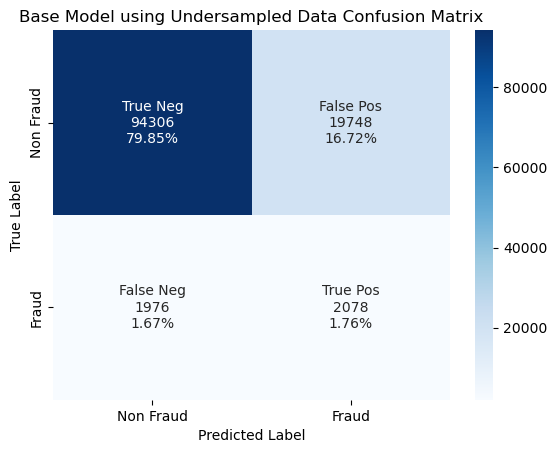

Metrics when threshold is 0.65: 

False Positive Rate: 0.1731460536237221
Recall: 0.5125801677355698
Precision: 0.09520755062769175
Accuracy: 0.816066650861923
F1: 0.16058732612055643
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.66


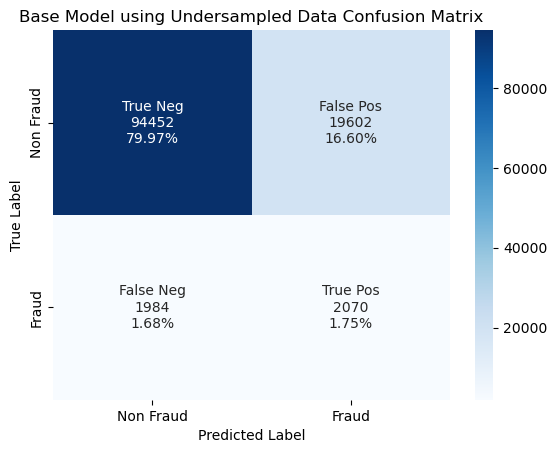

Metrics when threshold is 0.66: 

False Positive Rate: 0.17186595823031195
Recall: 0.5106068080907745
Precision: 0.09551495016611296
Accuracy: 0.8172350729840485
F1: 0.1609266889528104
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.67


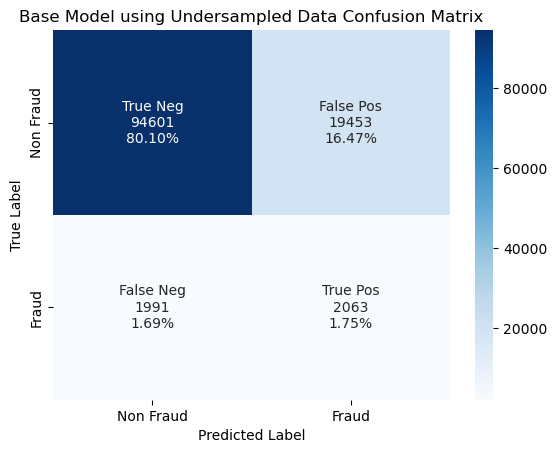

Metrics when threshold is 0.67: 

False Positive Rate: 0.17055955950690024
Recall: 0.5088801184015787
Precision: 0.09588213422569251
Accuracy: 0.8184373624140617
F1: 0.16136096988658585
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.68


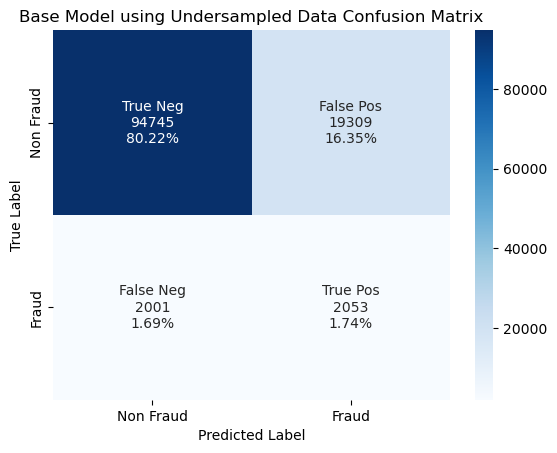

Metrics when threshold is 0.68: 

False Positive Rate: 0.1692969996668245
Recall: 0.5064134188455847
Precision: 0.09610523359236027
Accuracy: 0.8195719172282995
F1: 0.1615517784073025
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.69


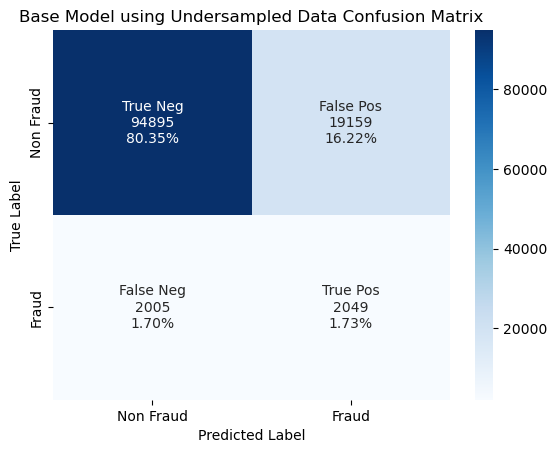

Metrics when threshold is 0.69: 

False Positive Rate: 0.1679818331667456
Recall: 0.505426739023187
Precision: 0.09661448509996227
Accuracy: 0.8208080739662005
F1: 0.16221993508035784
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.7


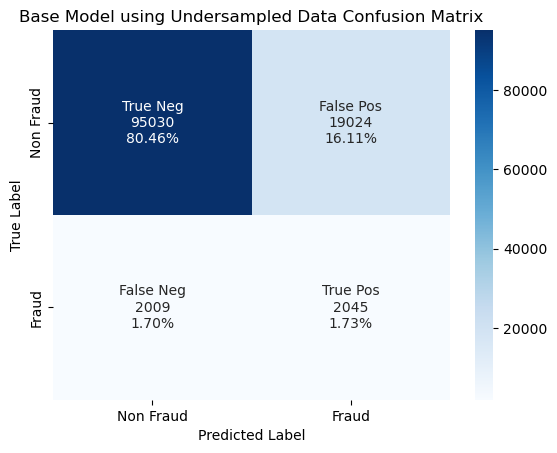

Metrics when threshold is 0.7: 

False Positive Rate: 0.16679818331667456
Recall: 0.5044400592007894
Precision: 0.09706203426835636
Accuracy: 0.8219172282995225
F1: 0.16279902877841024
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835


In [112]:
threshold = np.round(np.arange(0.3, 0.71, 0.01), 2)
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary_rus = (y_pred_rus > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary_rus)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Base Model using Undersampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    avg_prec_score_rus = average_precision_score(y_test, y_pred_rus)

    print(f"Metrics when threshold is {thresh}: ")
    print()
    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_rus}")
    print(f"Average Precision Score: {avg_prec_score_rus}")
    print("="*80)

    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_rus,
    }
    results.append(result)

df_result_rus = pd.DataFrame(results)

In [113]:
df_result_rus

Threshold  False Positive Rate    Recall  Precision  Accuracy        F1   
0        0.30             0.740711  0.931426   0.042784  0.282360  0.081810  \
1        0.31             0.704333  0.925752   0.044633  0.317294  0.085161   
2        0.32             0.661985  0.913912   0.046776  0.357783  0.088997   
3        0.33             0.609387  0.900839   0.049921  0.408126  0.094600   
4        0.34             0.575552  0.887519   0.051963  0.440343  0.098177   
5        0.35             0.538403  0.870005   0.054317  0.475616  0.102250   
6        0.36             0.510442  0.845338   0.055593  0.501770  0.104324   
7        0.37             0.471926  0.812531   0.057669  0.537838  0.107695   
8        0.38             0.419573  0.761717   0.060618  0.586650  0.112299   
9        0.39             0.357866  0.710656   0.065931  0.644486  0.120668   
10       0.40             0.300647  0.652442   0.071612  0.697743  0.129059   
11       0.41             0.256273  0.611495   0.078182  0.739188  0.138639   
12       0.42             0.235704  0.589788   0.081677  0.758306  0.143483   
13       0.43             0.201878  0.553527   0.088804  0.789726  0.153054   
14       0.44             0.197406  0.545387   0.089420  0.793765  0.153648   
15       0.45             0.195609  0.542181   0.089685  0.795391  0.153911   
16       0.46             0.194627  0.539467   0.089686  0.796246  0.153803   
17       0.47             0.193601  0.538727   0.090006  0.797211  0.154243   
18       0.48             0.192637  0.538481   0.090378  0.798134  0.154779   
19       0.49             0.191427  0.537000   0.090671  0.799252  0.155145   
20       0.50             0.189971  0.533547   0.090768  0.800538  0.155143   
21       0.51             0.189024  0.532067   0.090951  0.801402  0.155347   
22       0.52             0.187999  0.531327   0.091287  0.802367  0.155805   
23       0.53             0.186947  0.530340   0.091599  0.803349  0.156216   
24       0.54             0.185859  0.529107   0.091891  0.804357  0.156586   
25       0.55             0.184904  0.528614   0.092243  0.805263  0.157077   
26       0.56             0.183659  0.527134   0.092575  0.806414  0.157491   
27       0.57             0.182431  0.525654   0.092903  0.807549  0.157899   
28       0.58             0.181318  0.523927   0.093142  0.808565  0.158165   
29       0.59             0.180046  0.522694   0.093538  0.809750  0.158679   
30       0.60             0.178950  0.521214   0.093815  0.810758  0.159010   
31       0.61             0.177775  0.519487   0.094093  0.811833  0.159328   
32       0.62             0.176811  0.517514   0.094233  0.812697  0.159435   
33       0.63             0.175724  0.516527   0.094597  0.813713  0.159908   
34       0.64             0.174514  0.514307   0.094820  0.814805  0.160120   
35       0.65             0.173146  0.512580   0.095208  0.816067  0.160587   
36       0.66             0.171866  0.510607   0.095515  0.817235  0.160927   
37       0.67             0.170560  0.508880   0.095882  0.818437  0.161361   
38       0.68             0.169297  0.506413   0.096105  0.819572  0.161552   
39       0.69             0.167982  0.505427   0.096614  0.820808  0.162220   
40       0.70             0.166798  0.504440   0.097062  0.821917  0.162799   

         AUC  
0   0.743503  
1   0.743503  
2   0.743503  
3   0.743503  
4   0.743503  
5   0.743503  
6   0.743503  
7   0.743503  
8   0.743503  
9   0.743503  
10  0.743503  
11  0.743503  
12  0.743503  
13  0.743503  
14  0.743503  
15  0.743503  
16  0.743503  
17  0.743503  
18  0.743503  
19  0.743503  
20  0.743503  
21  0.743503  
22  0.743503  
23  0.743503  
24  0.743503  
25  0.743503  
26  0.743503  
27  0.743503  
28  0.743503  
29  0.743503  
30  0.743503  
31  0.743503  
32  0.743503  
33  0.743503  
34  0.743503  
35  0.743503  
36  0.743503  
37  0.743503  
38  0.743503  
39  0.743503  
40  0.743503

In [ ]:
K.clear_session()

# Oversampled

In [53]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_baseline/oversampled/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_auc", mode="max", patience=10)


# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_smote.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    # recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[auc])

    return model


In [54]:
## Oversampled Data
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.001)
model = create_baseline_model(adam)
history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/50
11397/11397 [==============================] - ETA: 0s - loss: 0.7279 - auc: 0.7458
Epoch 1: val_auc improved from -inf to 0.78661, saving model to ./model/model_reduced_features_baseline/oversampled/base_model_logloss_0.41_auc_0.79_checkpoint.h5
11397/11397 [==============================] - 97s 8ms/step - loss: 0.7279 - auc: 0.7458 - val_loss: 0.4118 - val_auc: 0.7866
Epoch 2/50
11397/11397 [==============================] - ETA: 0s - loss: 0.5264 - auc: 0.8118
Epoch 2: val_auc improved from 0.78661 to 0.78893, saving model to ./model/model_reduced_features_baseline/oversampled/base_model_logloss_0.40_auc_0.79_checkpoint.h5
11397/11397 [==============================] - 90s 8ms/step - loss: 0.5264 - auc: 0.8118 - val_loss: 0.4000 - val_auc: 0.7889
Epoch 3/50
11397/11397 [==============================] - ETA: 0s - loss: 0.5110 - auc: 0.8238
Epoch 3: val_auc improved from 0.78893 to 0.79621, saving model to ./model/model_reduced_features_baseline/oversampled/base_model_logl

<Axes: xlabel='epoch', ylabel='auc'>

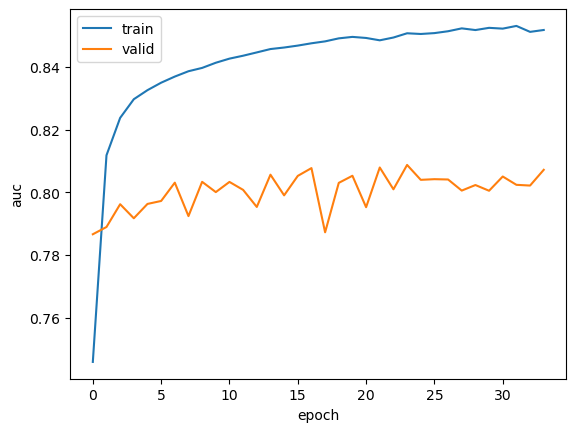

In [55]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [ ]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

In [56]:
y_pred = model.predict(X_test)
# using x test here

3691/3691 [==============================] - 5s 1ms/step


In [81]:
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras_smote = auc(fpr_keras, tpr_keras)
avg_prec_score = average_precision_score(y_test, y_pred)
print(f"AUC for Oversampled: {auc_keras_smote}")
print(f"Average Precision Score for Oversampled: {avg_prec_score}")

AUC for Oversampled: 0.8126203001029579
Average Precision Score for Oversampled: 0.25861530291020735


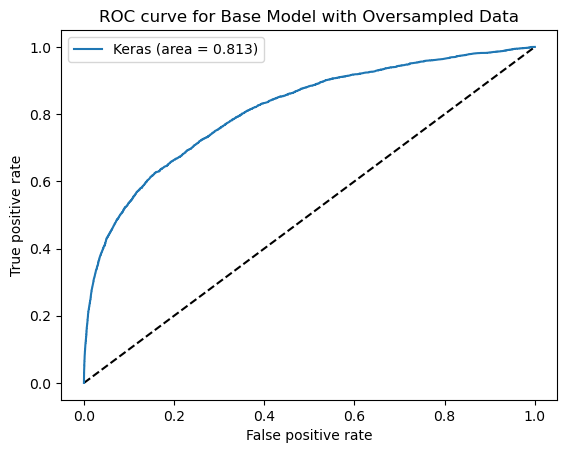

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras_smote))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Base Model with Oversampled Data')
plt.legend(loc='best')
plt.show()

In [83]:
temp = X_test.copy()
temp['predicted'] = y_pred
temp['true'] = y_test
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

In [84]:
temp.head()

ProductCD  card3  card4  card6  addr2  R_emaildomain       D12   
7681            1     42      4      1     65             31 -1.416108  \
570242          4     42      2      2     65             31  0.614603   
340470          0     73      2      1     43             19 -0.801775   
131781          2     42      4      1     65              1  0.614603   
472772          4     42      4      2     65             31  0.614603   

             D13  M1  M2  M3  M4  M5  M7  M8  M9       V18       V30   
7681   -1.819843   2   2   2   3   2   2   2   2 -0.540222 -0.664176  \
570242  0.533902   1   1   1   0   0   0   0   0 -0.540222 -0.664176   
340470  0.533902   2   2   2   2   2   2   2   2 -0.540222 -0.664176   
131781 -1.833103   2   2   2   3   2   2   2   2  1.683197 -0.664176   
472772  0.533902   1   1   1   3   2   0   1   1 -0.540222  1.202141   

             V40       V60       V70       V80       V81       V91      V173   
7681   -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703  \
570242 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
340470 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
131781  2.095003  1.524002 -0.664404  1.464129  1.372312 -0.694394 -1.102703   
472772 -0.504170 -0.519610  1.204801 -0.521953 -0.508172  1.128298  0.892322   

            V174      V223  id_12  id_13  id_15  id_16  id_17  id_19  id_20   
7681   -1.135389 -1.072947      1     54      0      0     59    389     51  \
570242  0.854764  0.815741      2     54      3      2    104    522    394   
340470  0.854764  0.815741      2     54      3      2    104    522    394   
131781 -1.135389 -1.072947      1     38      1      1     59    227    125   
472772  0.854764  0.815741      2     54      3      2    104    522    394   

        id_28  id_29  id_30  id_33  id_35  id_36  id_37  DeviceType   
7681        0      0     16    132      1      0      1           0  \
570242      2      2     74    260      2      2      2           1   
340470      2      2     74    260      2      2      2           1   
131781      1      1     56     14      1      0      1           2   
472772      2      2     74    260      2      2      2           1   

        DeviceInfo  R_parent_domain  R_domain_name  R_top_level_domain   
7681          1769               16             24                   8  \
570242        1735               16             24                   8   
340470        1735               15             17                   2   
131781        1727                1              1                   2   
472772        1735               16             24                   8   

        device_name  device_version  os_name  os_version  TransactionAmt   
7681              6             293        3           5       -0.460052  \
570242           13             293        7          68       -0.075376   
340470           13             293        7          68       -0.256120   
131781           12             293        6          11        1.107920   
472772           13             293        7          68       -0.430993   

        predicted  true  
7681     0.000088     0  
570242   0.417885     0  
340470   0.571607     0  
131781   0.018653     0  
472772   0.086910     0

In [ ]:
# per row consider apakah dia tp, fp, fn, tn dengan bikin 4 kolom
# group by bin
# dihitung cumulative sum untuk setiap tp fp fn tn
# ini berubah seiring threshold berubah
# non-cumulative ngitung precision itu di bin itu doang (bins nya adalah populasi)
# fraud rate
# masukin y_val
# transaksi masuk, kemungkinan dia dihitung fraud berapa? -> fraud rate

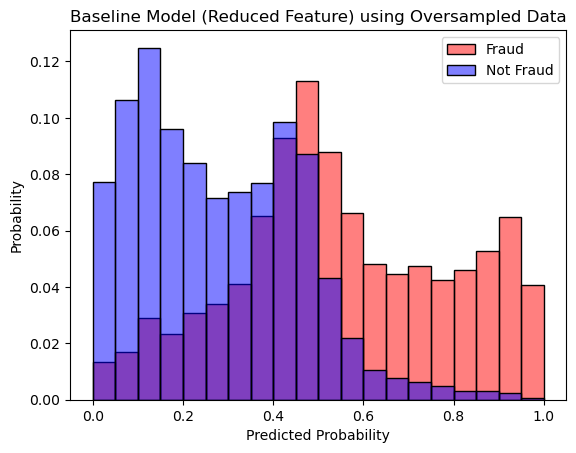

In [85]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model (Reduced Feature) using Oversampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

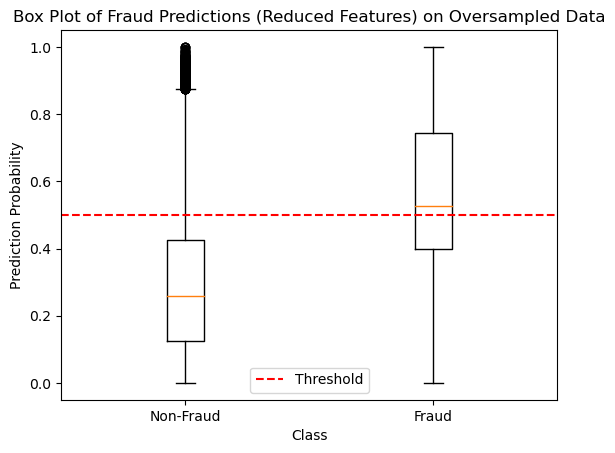

In [95]:
fraud_cases = y_pred[y_test==1]
non_fraud_cases = y_pred[y_test==0]
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Oversampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.39. Let's calculate the confusion matrix

Threshold: 0.3


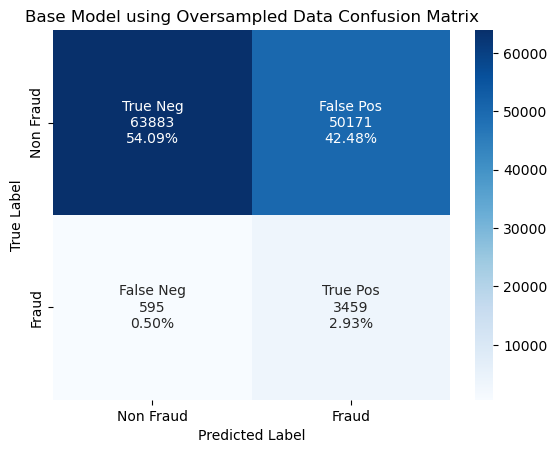

Metrics when threshold is 0.3: 
False Positive Rate: 0.43988812316972664
Recall: 0.8532313764183522
Precision: 0.06449748275219094
Accuracy: 0.5701730619433061
F1: 0.11992926981485336
AUC: 0.8126203001029579
Threshold: 0.31


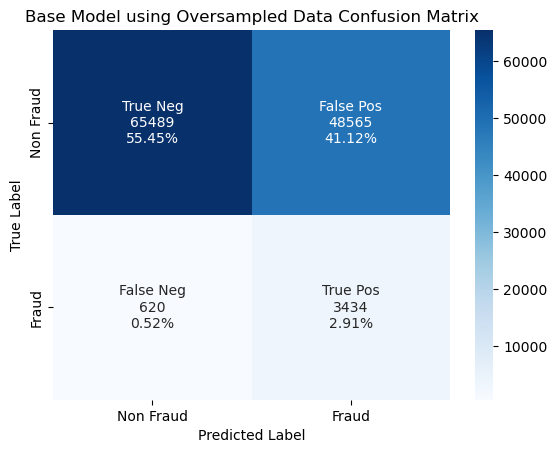

Metrics when threshold is 0.31: 
False Positive Rate: 0.4258070738422151
Recall: 0.8470646275283671
Precision: 0.06603973153329872
Accuracy: 0.583559115385918
F1: 0.12252689418942787
AUC: 0.8126203001029579
Threshold: 0.32


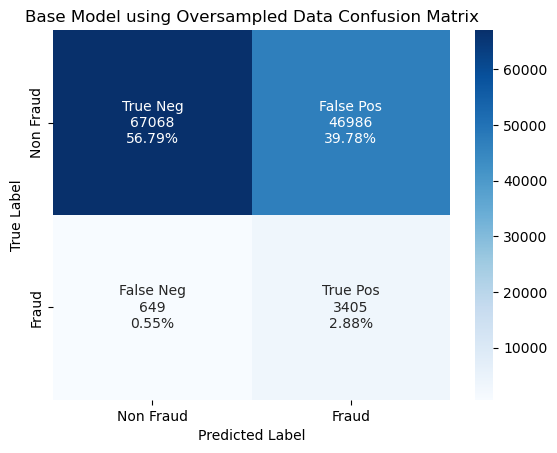

Metrics when threshold is 0.32: 
False Positive Rate: 0.41196275448471775
Recall: 0.8399111988159842
Precision: 0.0675715901649104
Accuracy: 0.5966826971924002
F1: 0.12508035632289466
AUC: 0.8126203001029579
Threshold: 0.33


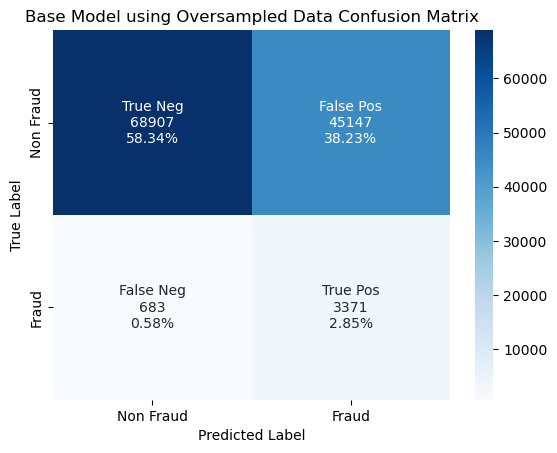

Metrics when threshold is 0.33: 
False Positive Rate: 0.3958388131937503
Recall: 0.8315244203256044
Precision: 0.06947936848180057
Accuracy: 0.611965319876723
F1: 0.1282431712698775
AUC: 0.8126203001029579
Threshold: 0.34


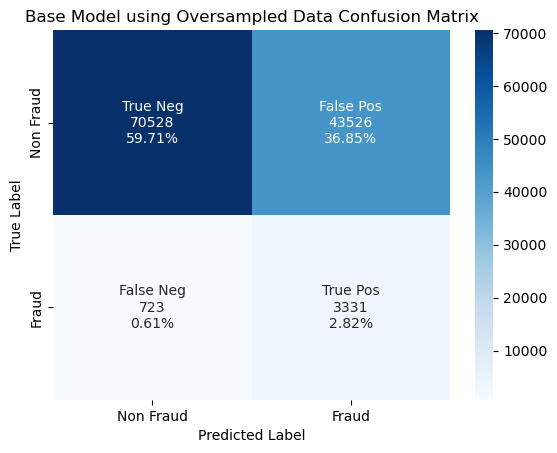

Metrics when threshold is 0.34: 
False Positive Rate: 0.3816262472162309
Recall: 0.8216576221016281
Precision: 0.07108863136777856
Accuracy: 0.6253513733193349
F1: 0.13085580719294454
AUC: 0.8126203001029579
Threshold: 0.35


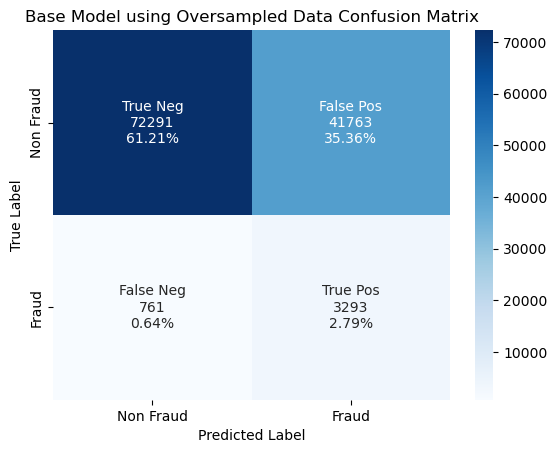

Metrics when threshold is 0.35: 
False Positive Rate: 0.3661686569519701
Recall: 0.8122841637888505
Precision: 0.07308682528409091
Accuracy: 0.6399566498459037
F1: 0.13410710649562207
AUC: 0.8126203001029579
Threshold: 0.36


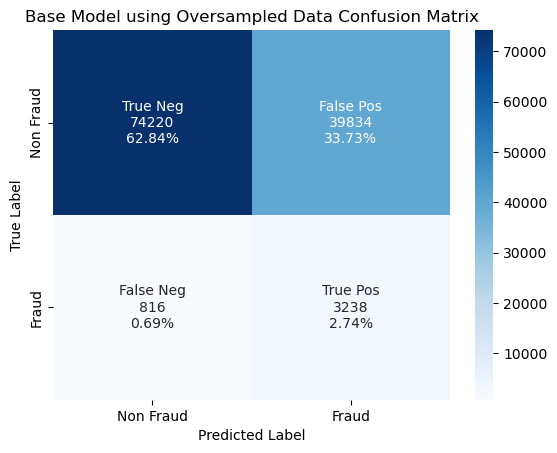

Metrics when threshold is 0.36: 
False Positive Rate: 0.3492556157609553
Recall: 0.798717316230883
Precision: 0.07517644873699851
Accuracy: 0.6558234835912893
F1: 0.1374188346135891
AUC: 0.8126203001029579
Threshold: 0.37


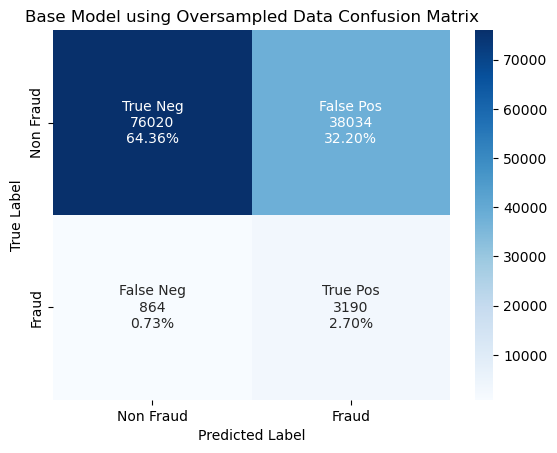

Metrics when threshold is 0.37: 
False Positive Rate: 0.3334736177600084
Recall: 0.7868771583621115
Precision: 0.07738210751018824
Accuracy: 0.6706573644461001
F1: 0.14090728389063123
AUC: 0.8126203001029579
Threshold: 0.38


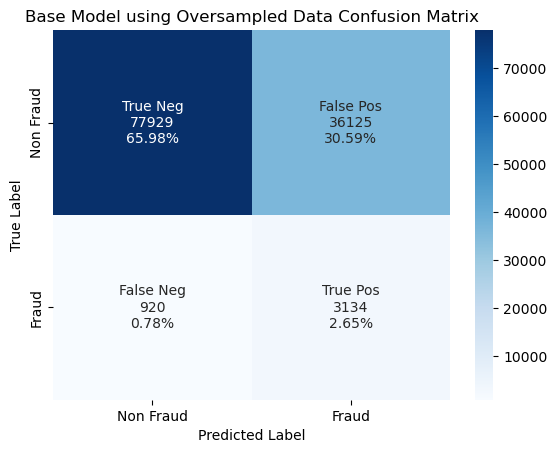

Metrics when threshold is 0.38: 
False Positive Rate: 0.31673593210233747
Recall: 0.7730636408485446
Precision: 0.0798288290583051
Accuracy: 0.6863463948250753
F1: 0.144714058134971
AUC: 0.8126203001029579
Threshold: 0.39


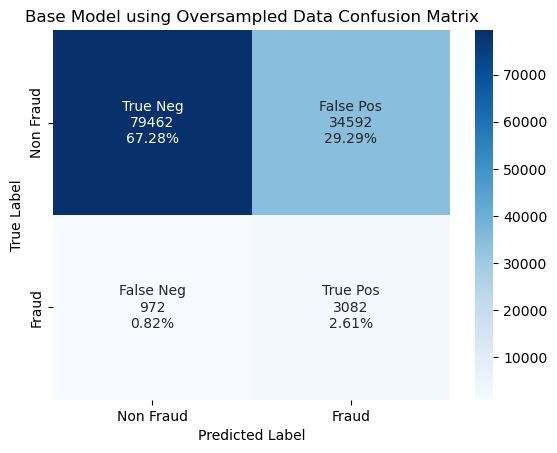

Metrics when threshold is 0.39: 
False Positive Rate: 0.30329493047153105
Recall: 0.7602368031573754
Precision: 0.08180708180708181
Accuracy: 0.6988857655704948
F1: 0.1477185582822086
AUC: 0.8126203001029579
Threshold: 0.4


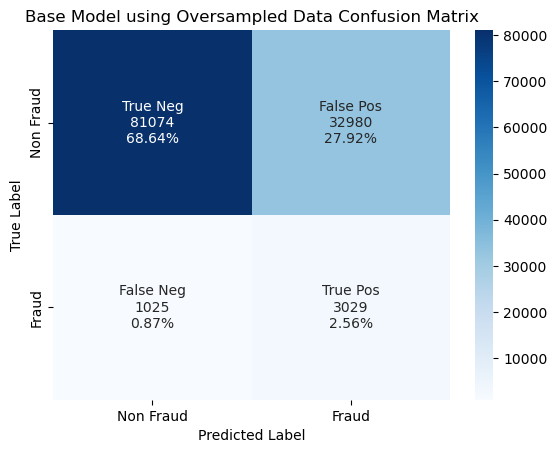

Metrics when threshold is 0.4: 
False Positive Rate: 0.28916127448401635
Recall: 0.7471632955106068
Precision: 0.08411785942403288
Accuracy: 0.7120855488197243
F1: 0.15121184134987395
AUC: 0.8126203001029579
Threshold: 0.41


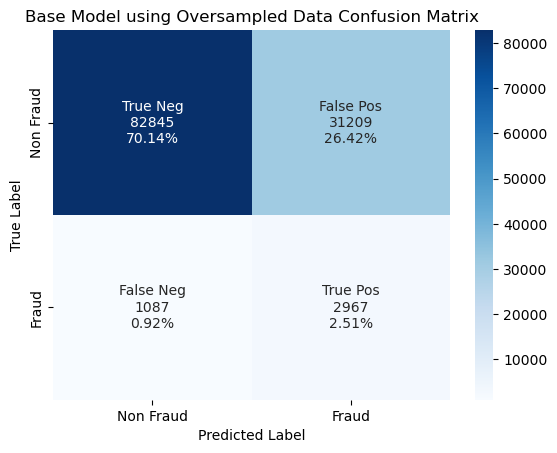

Metrics when threshold is 0.41: 
False Positive Rate: 0.27363354200641804
Recall: 0.7318697582634435
Precision: 0.08681530898876405
Accuracy: 0.7265553561147424
F1: 0.1552184148574418
AUC: 0.8126203001029579
Threshold: 0.42


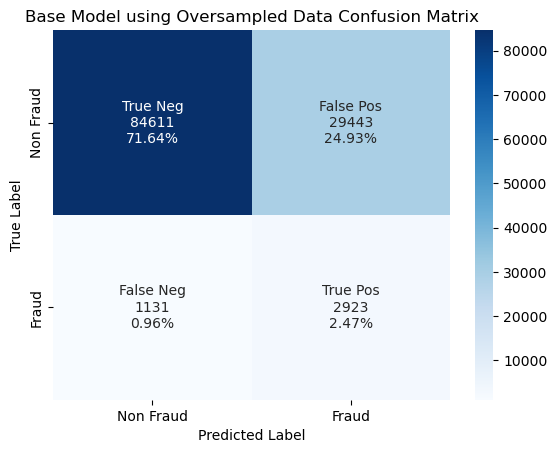

Metrics when threshold is 0.42: 
False Positive Rate: 0.25814964841215565
Recall: 0.7210162802170695
Precision: 0.09031081999629241
Accuracy: 0.7411352321603956
F1: 0.16051619989017024
AUC: 0.8126203001029579
Threshold: 0.43


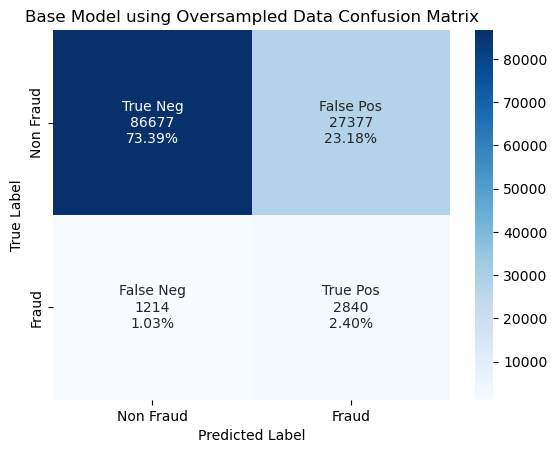

Metrics when threshold is 0.43: 
False Positive Rate: 0.24003542181773546
Recall: 0.7005426739023187
Precision: 0.09398682860641361
Accuracy: 0.7579249500457209
F1: 0.16573779580403256
AUC: 0.8126203001029579
Threshold: 0.44


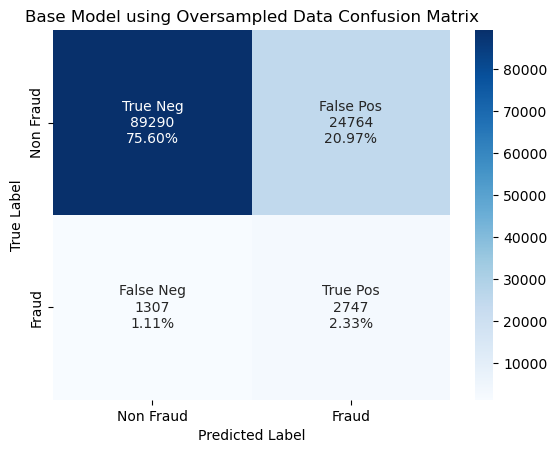

Metrics when threshold is 0.44: 
False Positive Rate: 0.21712522138636084
Recall: 0.6776023680315738
Precision: 0.09985096870342772
Accuracy: 0.7792613540149693
F1: 0.17405354031363854
AUC: 0.8126203001029579
Threshold: 0.45


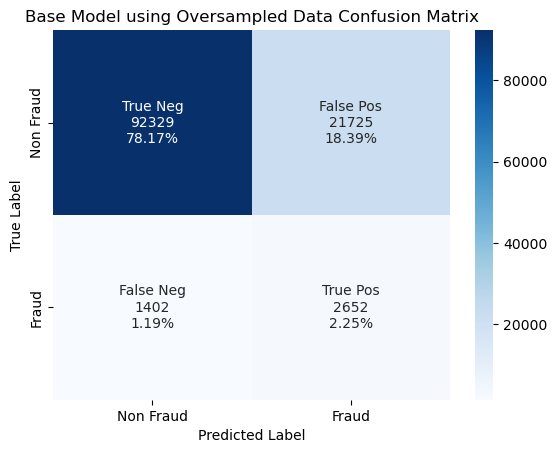

Metrics when threshold is 0.45: 
False Positive Rate: 0.19047994809476212
Recall: 0.65416872224963
Precision: 0.10879107355293925
Accuracy: 0.8041876926203136
F1: 0.18655692729766804
AUC: 0.8126203001029579
Threshold: 0.46


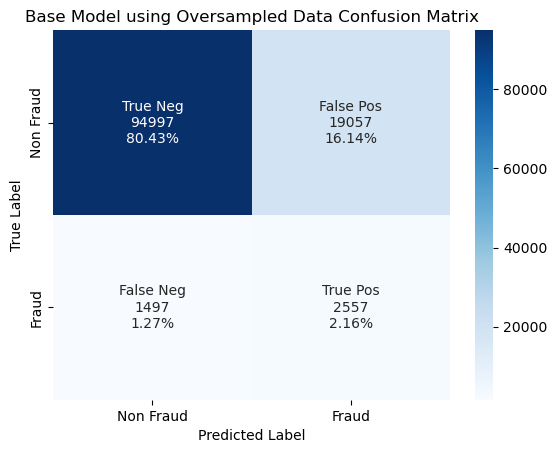

Metrics when threshold is 0.46: 
False Positive Rate: 0.1670875199466919
Recall: 0.6307350764676862
Precision: 0.11830295179050615
Accuracy: 0.8259728384190741
F1: 0.1992364033037245
AUC: 0.8126203001029579
Threshold: 0.47


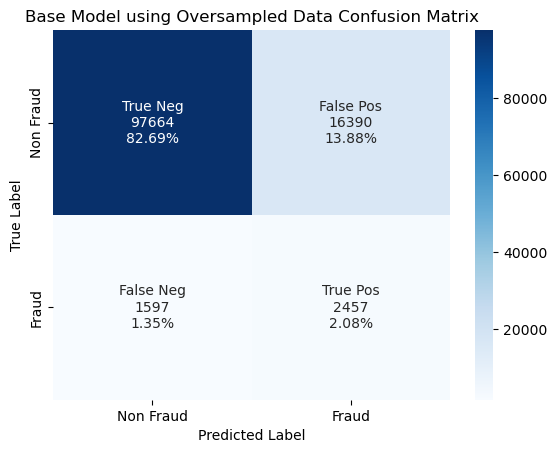

Metrics when threshold is 0.47: 
False Positive Rate: 0.1437038595752889
Recall: 0.6060680809077454
Precision: 0.13036557542314425
Accuracy: 0.847707183256003
F1: 0.2145757827169119
AUC: 0.8126203001029579
Threshold: 0.48


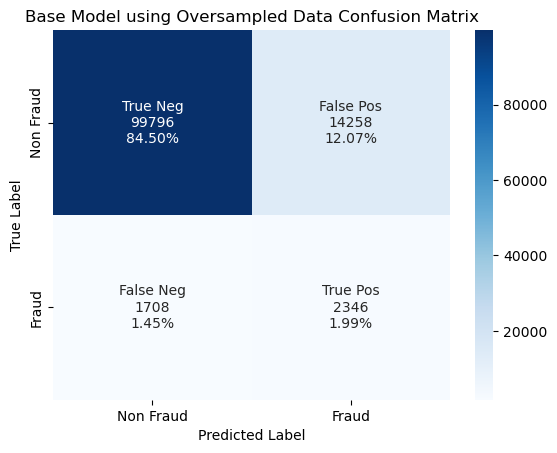

Metrics when threshold is 0.48: 
False Positive Rate: 0.12501095972083398
Recall: 0.5786877158362111
Precision: 0.14129125511924837
Accuracy: 0.8648186405662613
F1: 0.22712750508277665
AUC: 0.8126203001029579
Threshold: 0.49


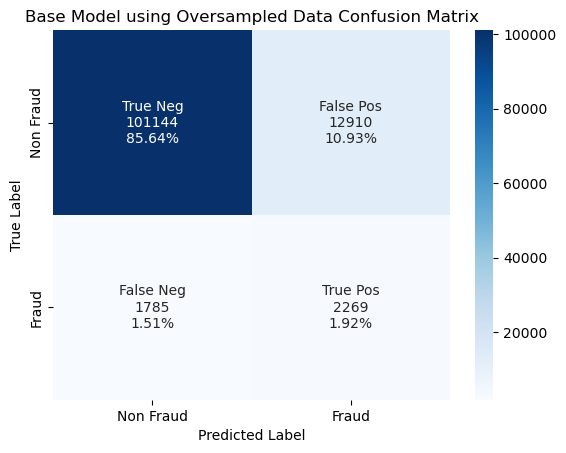

Metrics when threshold is 0.49: 
False Positive Rate: 0.11319199677345819
Recall: 0.5596941292550567
Precision: 0.14948283813162921
Accuracy: 0.8755799776475768
F1: 0.23594862995892474
AUC: 0.8126203001029579
Threshold: 0.5


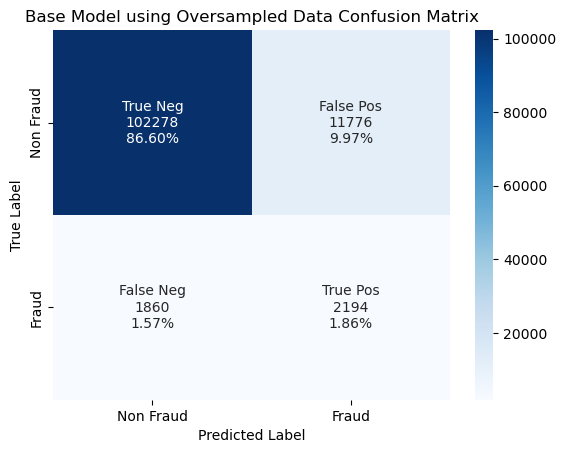

Metrics when threshold is 0.5: 
False Positive Rate: 0.10324933803286163
Recall: 0.5411938825851011
Precision: 0.15705082319255548
Accuracy: 0.8845463474108443
F1: 0.2434531735463826
AUC: 0.8126203001029579
Threshold: 0.51


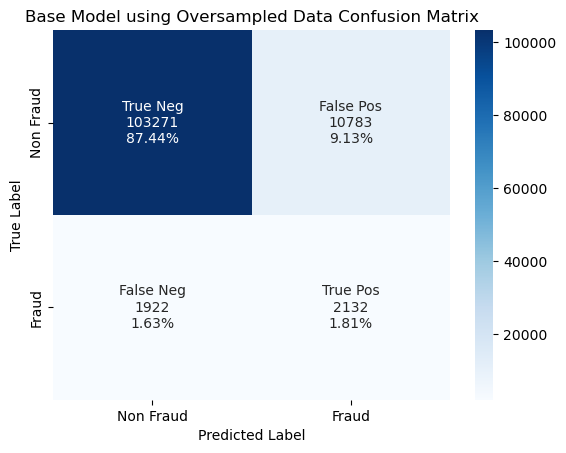

Metrics when threshold is 0.51: 
False Positive Rate: 0.09454293580233925
Recall: 0.5259003453379378
Precision: 0.16507936507936508
Accuracy: 0.8924289633217055
F1: 0.25128174907183687
AUC: 0.8126203001029579
Threshold: 0.52


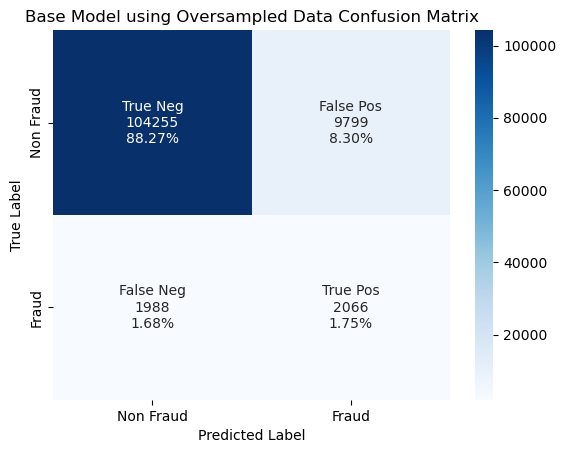

Metrics when threshold is 0.52: 
False Positive Rate: 0.0859154435618216
Recall: 0.5096201282683769
Precision: 0.17412557943531395
Accuracy: 0.9002015104819318
F1: 0.2595640429675231
AUC: 0.8126203001029579
Threshold: 0.53


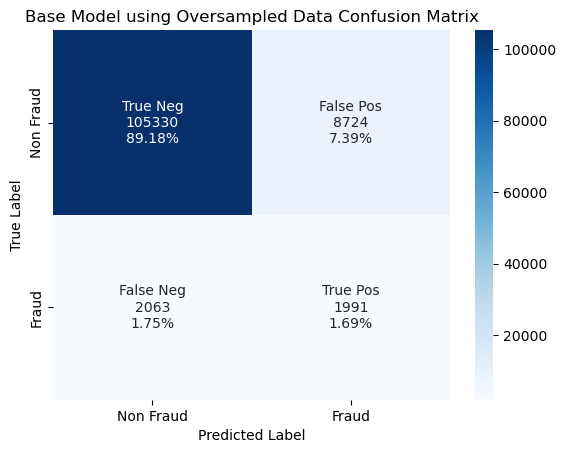

Metrics when threshold is 0.53: 
False Positive Rate: 0.07649008364458941
Recall: 0.4911198815984213
Precision: 0.18581427904806347
Accuracy: 0.9086683374538558
F1: 0.2696187961270229
AUC: 0.8126203001029579
Threshold: 0.54


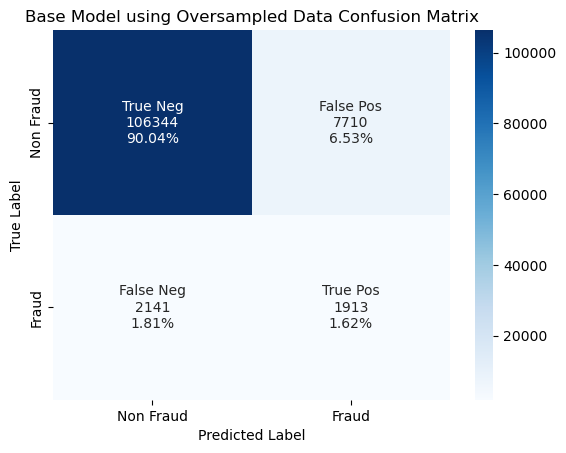

Metrics when threshold is 0.54: 
False Positive Rate: 0.06759955810405598
Recall: 0.4718796250616675
Precision: 0.19879455471266758
Accuracy: 0.9165932874995767
F1: 0.27973970900051176
AUC: 0.8126203001029579
Threshold: 0.55


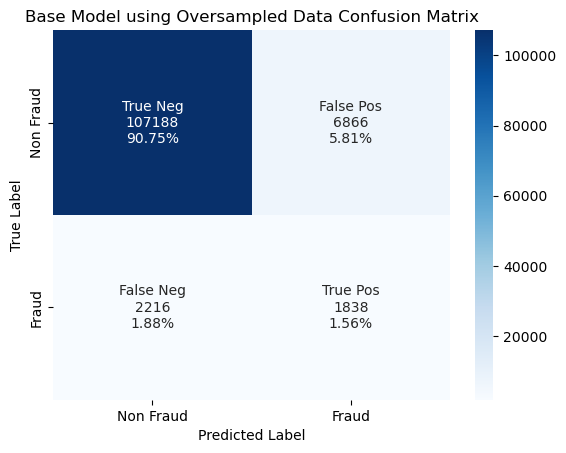

Metrics when threshold is 0.55: 
False Positive Rate: 0.06019955459694531
Recall: 0.4533793783917119
Precision: 0.21116727941176472
Accuracy: 0.9231042774409862
F1: 0.28813293619689606
AUC: 0.8126203001029579
Threshold: 0.56


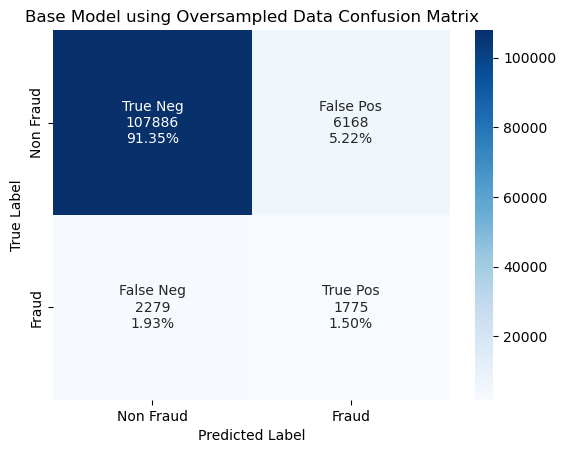

Metrics when threshold is 0.56: 
False Positive Rate: 0.05407964648324478
Recall: 0.43783917118894916
Precision: 0.22346720382726928
Accuracy: 0.928480712568158
F1: 0.2959073101608735
AUC: 0.8126203001029579
Threshold: 0.57


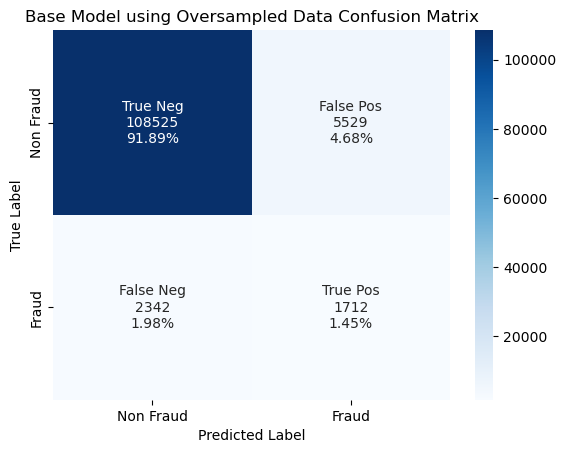

Metrics when threshold is 0.57: 
False Positive Rate: 0.04847703719290862
Recall: 0.4222989639861865
Precision: 0.23643143212263498
Accuracy: 0.9333576049039862
F1: 0.3031429836210713
AUC: 0.8126203001029579
Threshold: 0.58


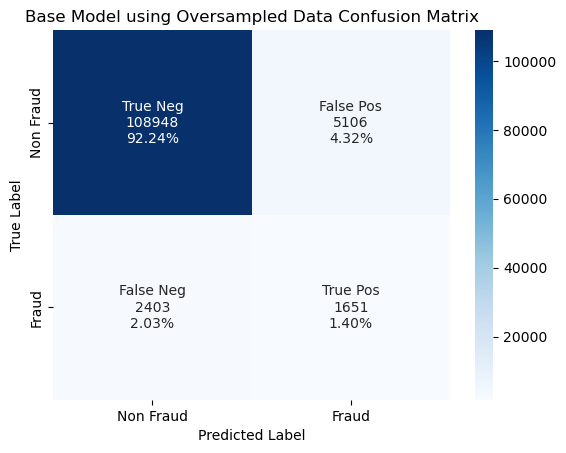

Metrics when threshold is 0.58: 
False Positive Rate: 0.044768267662686094
Recall: 0.4072520966946226
Precision: 0.2443392037886636
Accuracy: 0.9364225962678226
F1: 0.30542965498103786
AUC: 0.8126203001029579
Threshold: 0.59


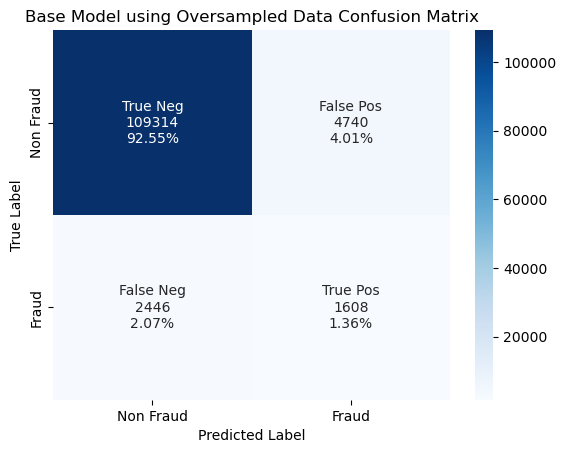

Metrics when threshold is 0.59: 
False Positive Rate: 0.04155926140249355
Recall: 0.39664528860384807
Precision: 0.2533081285444234
Accuracy: 0.9391573813797541
F1: 0.30917131320899827
AUC: 0.8126203001029579
Threshold: 0.6


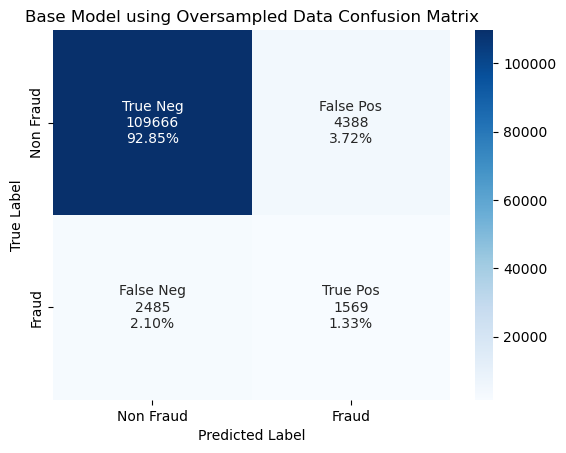

Metrics when threshold is 0.6: 
False Positive Rate: 0.038473004015641715
Recall: 0.38702516033547113
Precision: 0.2633876112136982
Accuracy: 0.9418074982219663
F1: 0.31345519928079113
AUC: 0.8126203001029579
Threshold: 0.61


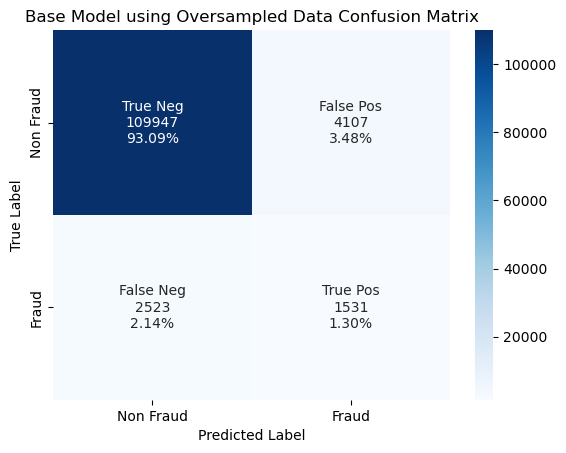

Metrics when threshold is 0.61: 
False Positive Rate: 0.03600925877216055
Recall: 0.37765170202269366
Precision: 0.27155019510464706
Accuracy: 0.9438649371761438
F1: 0.3159306644655386
AUC: 0.8126203001029579
Threshold: 0.62


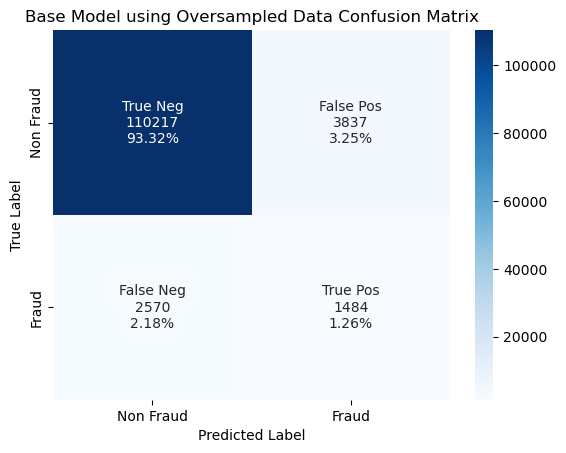

Metrics when threshold is 0.62: 
False Positive Rate: 0.033641959072018515
Recall: 0.36605821410952144
Precision: 0.27889494455929337
Accuracy: 0.945753039590883
F1: 0.3165866666666666
AUC: 0.8126203001029579
Threshold: 0.63


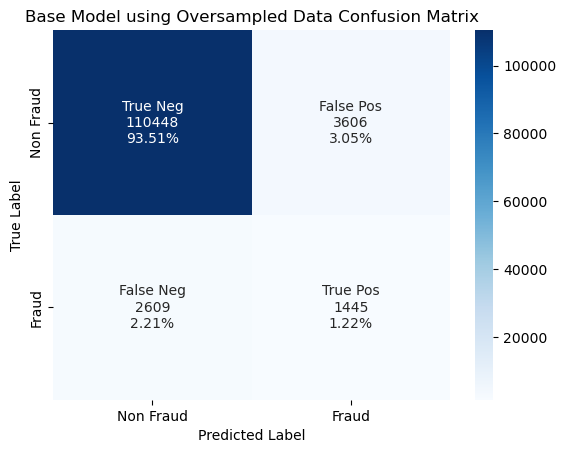

Metrics when threshold is 0.63: 
False Positive Rate: 0.031616602661896996
Recall: 0.35643808584114456
Precision: 0.28608196396753116
Accuracy: 0.9473786703694923
F1: 0.3174080175727622
AUC: 0.8126203001029579
Threshold: 0.64


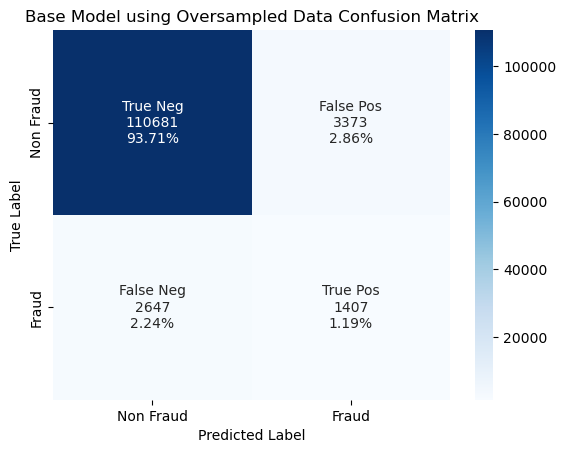

Metrics when threshold is 0.64: 
False Positive Rate: 0.02957371069844109
Recall: 0.34706462752836703
Precision: 0.2943514644351464
Accuracy: 0.9490297016290176
F1: 0.3185419968304279
AUC: 0.8126203001029579
Threshold: 0.65


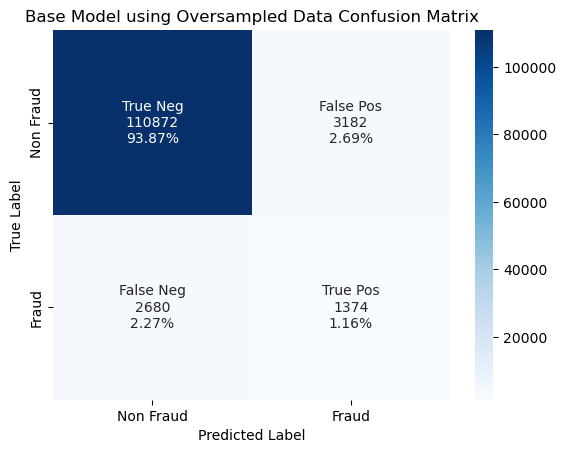

Metrics when threshold is 0.65: 
False Positive Rate: 0.027899065355007278
Recall: 0.33892451899358655
Precision: 0.3015803336259877
Accuracy: 0.9503674602905815
F1: 0.31916376306620203
AUC: 0.8126203001029579
Threshold: 0.66


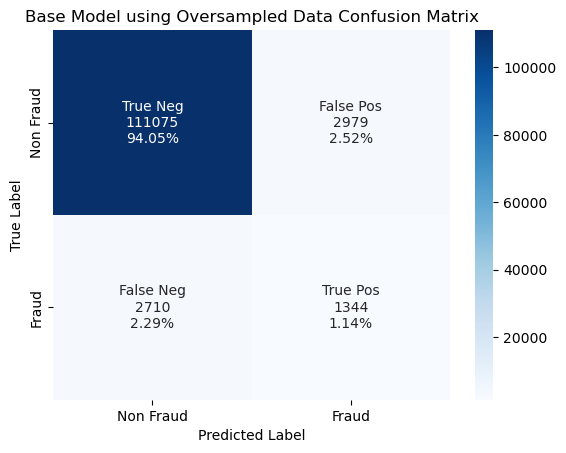

Metrics when threshold is 0.66: 
False Positive Rate: 0.026119206691567153
Recall: 0.33152442032560436
Precision: 0.3108952116585704
Accuracy: 0.9518322213567244
F1: 0.3208785961561418
AUC: 0.8126203001029579
Threshold: 0.67


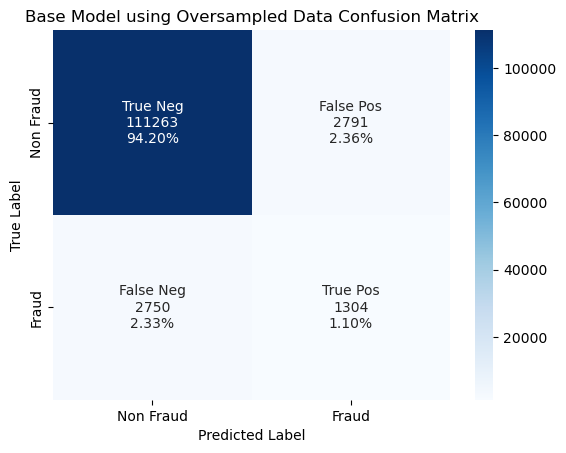

Metrics when threshold is 0.67: 
False Positive Rate: 0.024470864678134918
Recall: 0.321657622101628
Precision: 0.3184371184371184
Accuracy: 0.9530853117485691
F1: 0.32003926862191673
AUC: 0.8126203001029579
Threshold: 0.68


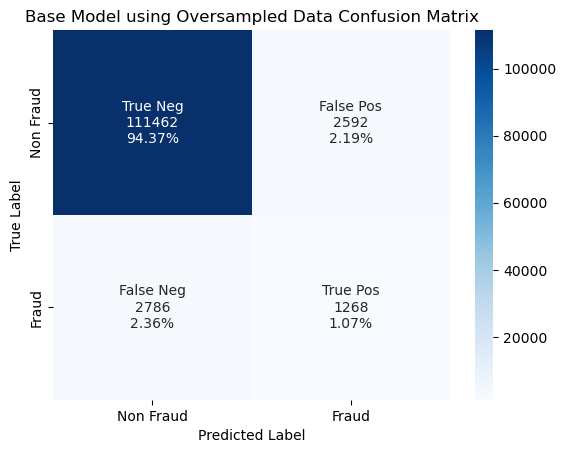

Metrics when threshold is 0.68: 
False Positive Rate: 0.022726077121363566
Recall: 0.3127775037000493
Precision: 0.32849740932642485
Accuracy: 0.9544654045449927
F1: 0.32044478140005056
AUC: 0.8126203001029579
Threshold: 0.69


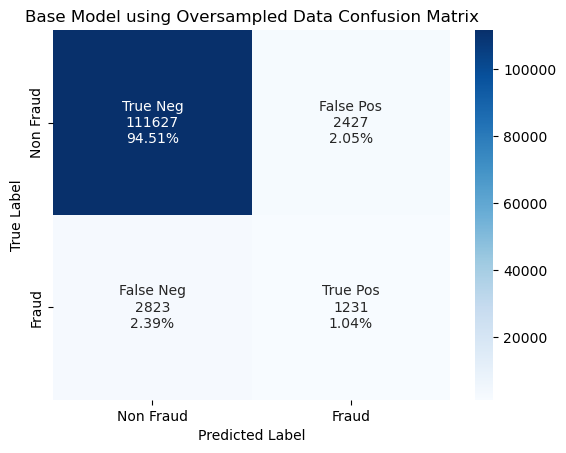

Metrics when threshold is 0.69: 
False Positive Rate: 0.021279393971276764
Recall: 0.30365071534287125
Precision: 0.33652268999453255
Accuracy: 0.955549158397399
F1: 0.31924273858921165
AUC: 0.8126203001029579
Threshold: 0.7


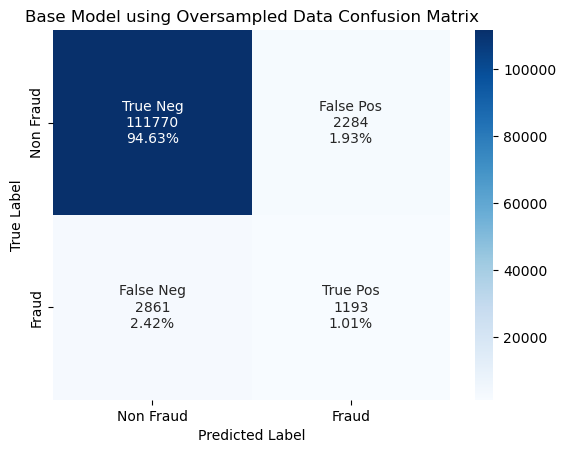

Metrics when threshold is 0.7: 
False Positive Rate: 0.0200256019078682
Recall: 0.2942772570300937
Precision: 0.34311187805579524
Accuracy: 0.956438175229451
F1: 0.3168237949807463
AUC: 0.8126203001029579


In [114]:
import pandas as pd
# threshold = [0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]
# using np.arange
threshold = np.round(np.arange(0.3, 0.71, 0.01), 2)
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary = (y_pred > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Base Model using Oversampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    print(f"Metrics when threshold is {thresh}: ")

    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_smote}")
    print("="*80)
    
    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_smote
    }
    results.append(result)

df_result_smote = pd.DataFrame(results)


In [101]:
np.round(np.arange(0.31, 0.51, 0.01), 2)

array([0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
       0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [115]:
df_result_smote

Threshold  False Positive Rate    Recall  Precision  Accuracy        F1   
0        0.30             0.439888  0.853231   0.064497  0.570173  0.119929  \
1        0.31             0.425807  0.847065   0.066040  0.583559  0.122527   
2        0.32             0.411963  0.839911   0.067572  0.596683  0.125080   
3        0.33             0.395839  0.831524   0.069479  0.611965  0.128243   
4        0.34             0.381626  0.821658   0.071089  0.625351  0.130856   
5        0.35             0.366169  0.812284   0.073087  0.639957  0.134107   
6        0.36             0.349256  0.798717   0.075176  0.655823  0.137419   
7        0.37             0.333474  0.786877   0.077382  0.670657  0.140907   
8        0.38             0.316736  0.773064   0.079829  0.686346  0.144714   
9        0.39             0.303295  0.760237   0.081807  0.698886  0.147719   
10       0.40             0.289161  0.747163   0.084118  0.712086  0.151212   
11       0.41             0.273634  0.731870   0.086815  0.726555  0.155218   
12       0.42             0.258150  0.721016   0.090311  0.741135  0.160516   
13       0.43             0.240035  0.700543   0.093987  0.757925  0.165738   
14       0.44             0.217125  0.677602   0.099851  0.779261  0.174054   
15       0.45             0.190480  0.654169   0.108791  0.804188  0.186557   
16       0.46             0.167088  0.630735   0.118303  0.825973  0.199236   
17       0.47             0.143704  0.606068   0.130366  0.847707  0.214576   
18       0.48             0.125011  0.578688   0.141291  0.864819  0.227128   
19       0.49             0.113192  0.559694   0.149483  0.875580  0.235949   
20       0.50             0.103249  0.541194   0.157051  0.884546  0.243453   
21       0.51             0.094543  0.525900   0.165079  0.892429  0.251282   
22       0.52             0.085915  0.509620   0.174126  0.900202  0.259564   
23       0.53             0.076490  0.491120   0.185814  0.908668  0.269619   
24       0.54             0.067600  0.471880   0.198795  0.916593  0.279740   
25       0.55             0.060200  0.453379   0.211167  0.923104  0.288133   
26       0.56             0.054080  0.437839   0.223467  0.928481  0.295907   
27       0.57             0.048477  0.422299   0.236431  0.933358  0.303143   
28       0.58             0.044768  0.407252   0.244339  0.936423  0.305430   
29       0.59             0.041559  0.396645   0.253308  0.939157  0.309171   
30       0.60             0.038473  0.387025   0.263388  0.941807  0.313455   
31       0.61             0.036009  0.377652   0.271550  0.943865  0.315931   
32       0.62             0.033642  0.366058   0.278895  0.945753  0.316587   
33       0.63             0.031617  0.356438   0.286082  0.947379  0.317408   
34       0.64             0.029574  0.347065   0.294351  0.949030  0.318542   
35       0.65             0.027899  0.338925   0.301580  0.950367  0.319164   
36       0.66             0.026119  0.331524   0.310895  0.951832  0.320879   
37       0.67             0.024471  0.321658   0.318437  0.953085  0.320039   
38       0.68             0.022726  0.312778   0.328497  0.954465  0.320445   
39       0.69             0.021279  0.303651   0.336523  0.955549  0.319243   
40       0.70             0.020026  0.294277   0.343112  0.956438  0.316824   

        AUC  
0   0.81262  
1   0.81262  
2   0.81262  
3   0.81262  
4   0.81262  
5   0.81262  
6   0.81262  
7   0.81262  
8   0.81262  
9   0.81262  
10  0.81262  
11  0.81262  
12  0.81262  
13  0.81262  
14  0.81262  
15  0.81262  
16  0.81262  
17  0.81262  
18  0.81262  
19  0.81262  
20  0.81262  
21  0.81262  
22  0.81262  
23  0.81262  
24  0.81262  
25  0.81262  
26  0.81262  
27  0.81262  
28  0.81262  
29  0.81262  
30  0.81262  
31  0.81262  
32  0.81262  
33  0.81262  
34  0.81262  
35  0.81262  
36  0.81262  
37  0.81262  
38  0.81262  
39  0.81262  
40  0.81262

In [116]:
df_result_rus

Threshold  False Positive Rate    Recall  Precision  Accuracy        F1   
0        0.30             0.740711  0.931426   0.042784  0.282360  0.081810  \
1        0.31             0.704333  0.925752   0.044633  0.317294  0.085161   
2        0.32             0.661985  0.913912   0.046776  0.357783  0.088997   
3        0.33             0.609387  0.900839   0.049921  0.408126  0.094600   
4        0.34             0.575552  0.887519   0.051963  0.440343  0.098177   
5        0.35             0.538403  0.870005   0.054317  0.475616  0.102250   
6        0.36             0.510442  0.845338   0.055593  0.501770  0.104324   
7        0.37             0.471926  0.812531   0.057669  0.537838  0.107695   
8        0.38             0.419573  0.761717   0.060618  0.586650  0.112299   
9        0.39             0.357866  0.710656   0.065931  0.644486  0.120668   
10       0.40             0.300647  0.652442   0.071612  0.697743  0.129059   
11       0.41             0.256273  0.611495   0.078182  0.739188  0.138639   
12       0.42             0.235704  0.589788   0.081677  0.758306  0.143483   
13       0.43             0.201878  0.553527   0.088804  0.789726  0.153054   
14       0.44             0.197406  0.545387   0.089420  0.793765  0.153648   
15       0.45             0.195609  0.542181   0.089685  0.795391  0.153911   
16       0.46             0.194627  0.539467   0.089686  0.796246  0.153803   
17       0.47             0.193601  0.538727   0.090006  0.797211  0.154243   
18       0.48             0.192637  0.538481   0.090378  0.798134  0.154779   
19       0.49             0.191427  0.537000   0.090671  0.799252  0.155145   
20       0.50             0.189971  0.533547   0.090768  0.800538  0.155143   
21       0.51             0.189024  0.532067   0.090951  0.801402  0.155347   
22       0.52             0.187999  0.531327   0.091287  0.802367  0.155805   
23       0.53             0.186947  0.530340   0.091599  0.803349  0.156216   
24       0.54             0.185859  0.529107   0.091891  0.804357  0.156586   
25       0.55             0.184904  0.528614   0.092243  0.805263  0.157077   
26       0.56             0.183659  0.527134   0.092575  0.806414  0.157491   
27       0.57             0.182431  0.525654   0.092903  0.807549  0.157899   
28       0.58             0.181318  0.523927   0.093142  0.808565  0.158165   
29       0.59             0.180046  0.522694   0.093538  0.809750  0.158679   
30       0.60             0.178950  0.521214   0.093815  0.810758  0.159010   
31       0.61             0.177775  0.519487   0.094093  0.811833  0.159328   
32       0.62             0.176811  0.517514   0.094233  0.812697  0.159435   
33       0.63             0.175724  0.516527   0.094597  0.813713  0.159908   
34       0.64             0.174514  0.514307   0.094820  0.814805  0.160120   
35       0.65             0.173146  0.512580   0.095208  0.816067  0.160587   
36       0.66             0.171866  0.510607   0.095515  0.817235  0.160927   
37       0.67             0.170560  0.508880   0.095882  0.818437  0.161361   
38       0.68             0.169297  0.506413   0.096105  0.819572  0.161552   
39       0.69             0.167982  0.505427   0.096614  0.820808  0.162220   
40       0.70             0.166798  0.504440   0.097062  0.821917  0.162799   

         AUC  
0   0.743503  
1   0.743503  
2   0.743503  
3   0.743503  
4   0.743503  
5   0.743503  
6   0.743503  
7   0.743503  
8   0.743503  
9   0.743503  
10  0.743503  
11  0.743503  
12  0.743503  
13  0.743503  
14  0.743503  
15  0.743503  
16  0.743503  
17  0.743503  
18  0.743503  
19  0.743503  
20  0.743503  
21  0.743503  
22  0.743503  
23  0.743503  
24  0.743503  
25  0.743503  
26  0.743503  
27  0.743503  
28  0.743503  
29  0.743503  
30  0.743503  
31  0.743503  
32  0.743503  
33  0.743503  
34  0.743503  
35  0.743503  
36  0.743503  
37  0.743503  
38  0.743503  
39  0.743503  
40  0.743503

In [117]:
df_result_smote.to_csv('hasil baseline smote threshold.csv')
df_result_rus.to_csv('hasil baseline rus threshold.csv')